# Setup

## Libraries

In [1]:
# using LinearAlgebra
using SparseArrays
# using Random
using CairoMakie
# using Statistics
# using ProgressMeter
using DataFrames
using DelimitedFiles

In [2]:
include("EchoStateNetworks.jl")
using .EchoStateNetworks
include("ONReservoir.jl")
using .ONReservoir
include("TurningError.jl")
using .TurningError
include("TestingFunctions.jl")
using .TestingFunctions

## Read in Lorenz testing data

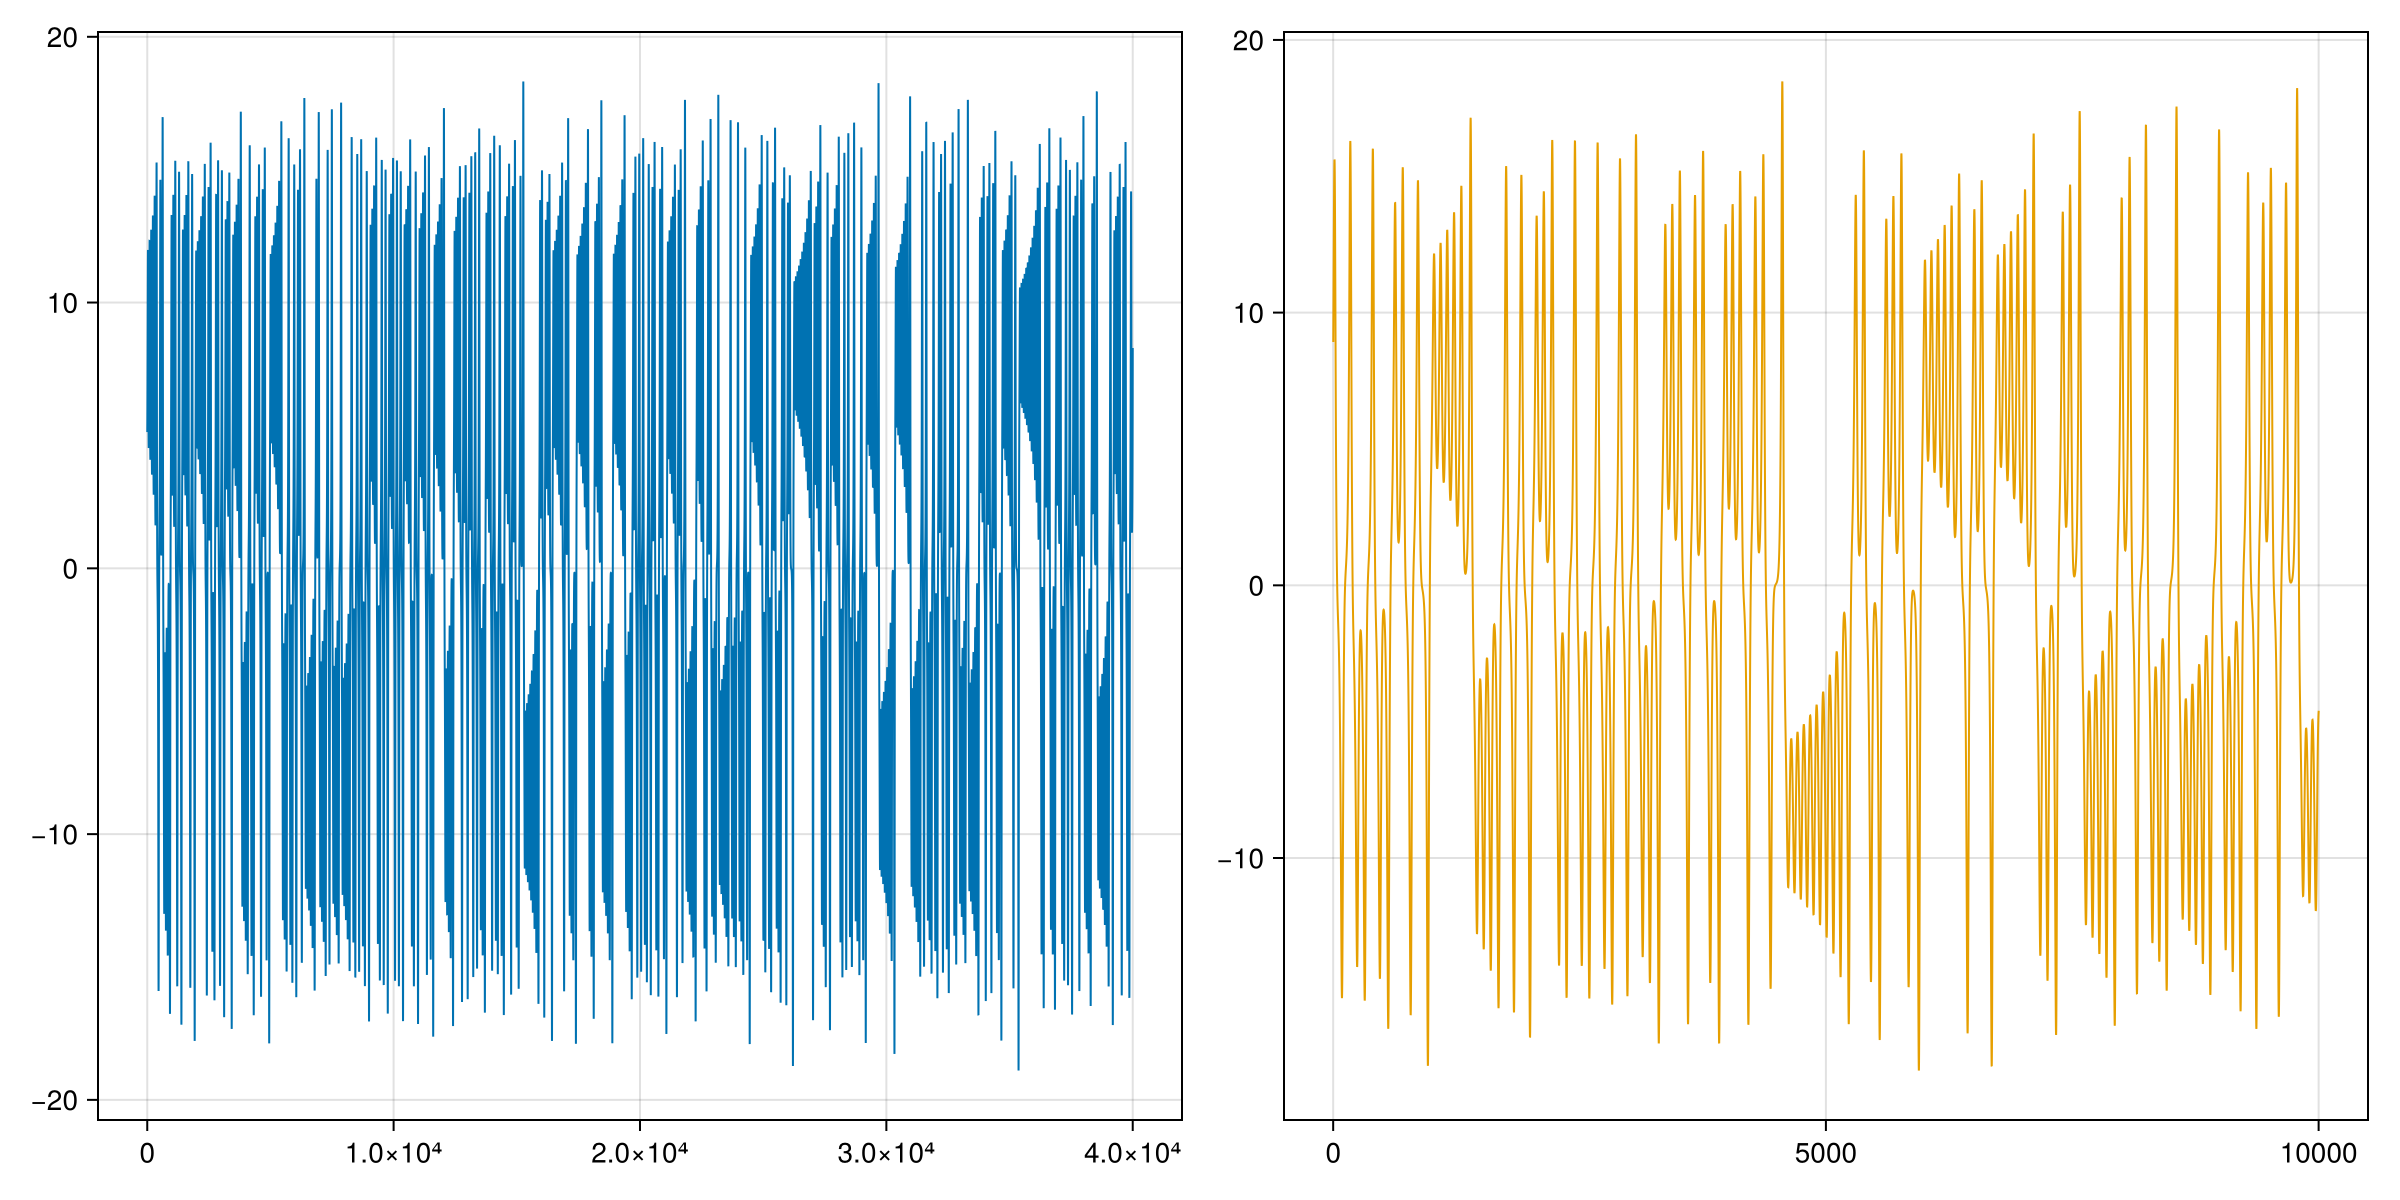

In [3]:
lo_train = vec(readdlm("lorenz_train.txt"))
lo_test = vec(readdlm("lorenz_test.txt"))

fig = Figure( size = (1200,600) )
lines!(Axis(fig[1,1]), lo_train; linewidth = 1.0, color = Cycled(1))
lines!(Axis(fig[1,2]), lo_test; linewidth = 1.0, color = Cycled(2))
fig

# Demonstrations

## Testing ON and reservoir creation

In [4]:
test_ON_part_adjacency = [
    0.7 0.1 0.2;
    0 0.7 0.3;
    0.4 0 0.6
]

k = 8
d = 3
ρ = 2.0
α = 1.0
η = 1/maximum(lo_train)
β = 0.001

ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=3, ON_part_adjacency=test_ON_part_adjacency)

DataFrame(ESN_params.V_rec, :auto)

24×24 DataFrame
 Row │ x1        x2        x3        x4         x5        x6        x7         ⋯
     │ Float64   Float64   Float64   Float64    Float64   Float64   Float64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.0       0.364162  0.0       0.0        0.0       0.0       0.0        ⋯
   2 │ 0.364162  0.0       0.0       0.693979   0.0       0.243632  0.0
   3 │ 0.0       0.0       0.0       0.0        0.0       0.0       0.0
   4 │ 0.0       0.693979  0.0       0.0        0.416944  0.0       0.0
   5 │ 0.0       0.0       0.0       0.416944   0.0       0.0       0.27854    ⋯
   6 │ 0.0       0.243632  0.0       0.0        0.0       0.0       0.0
   7 │ 0.0       0.0       0.0       0.0        0.27854   0.0       0.0
   8 │ 0.456293  0.0       0.124944  0.0990137  0.0       0.815843  0.0
   9 │ 0.0       0.0       0.0       0.0        0.0       0.0       0.0        ⋯
  10 │ 0.0       0.0       0.0       0.0        0.0       0.0       0.0
  11 │ 0.0       0.0       0.0       0.0        0.0       0.0       0.0
  ⋮  │    ⋮         ⋮         ⋮          ⋮         ⋮         ⋮         ⋮       ⋱
  15 │ 0.0       0.0       0.0       0.0        0.0       0.0       0.0
  16 │ 0.0       0.0       0.0       0.0        0.0       0.0       0.0        ⋯
  17 │ 0.550138  0.0       0.0       0.0        0.0       0.0       0.0
  18 │ 0.0       0.550138  0.0       0.0        0.0       0.0       0.0
  19 │ 0.0       0.0       0.550138  0.0        0.0       0.0       0.0
  20 │ 0.0       0.0       0.0       0.550138   0.0       0.0       0.0        ⋯
  21 │ 0.0       0.0       0.0       0.0        0.550138  0.0       0.0
  22 │ 0.0       0.0       0.0       0.0        0.0       0.550138  0.0
  23 │ 0.0       0.0       0.0       0.0        0.0       0.0       0.550138
  24 │ 0.0       0.0       0.0       0.0        0.0       0.0       0.0        ⋯
                                                   17 columns and 3 rows omitted

In [5]:
m = 3
k = 4
part_connection=0.5
d = k*0.05
ρ = 1.2
α = 1.0
η = 1/maximum(lo_train)
β = 0.001
w = 1
τ = 2

window_size = (m-1)*τ
    
part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
num_partitions = length(unique_partitions_train)
# trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, ON_part_adjacency=trans_adjacency_matrix)

R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train)


part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
preds, test_states = one_step_pred(lo_test, ESN_params, R, S = train_states[end,:], partition_symbols=part_symbols_test)

([0.0, 0.0, 0.0, 0.0, 11.729144095198183, 14.76614042057266, 13.925464446612349, 14.651678975828872, 15.263428739336819, 15.708712343443624  …  -5.48445752129434, -5.257727862468051, -5.055611365773124, -4.87805617969299, -4.724792182738277, -4.59539075287845, -4.489317687320602, -4.405968630583567, -4.344716026497288, -4.304931261822643], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.9599548240891733 -0.3868350072626836 … 0.9480961106880152 0.6714048409946496; 0.9597576375678583 -0.38685976488635265 … 0.9484353373489071 0.6713567921019516])

In [6]:
trans_adjacency_matrix

6×6 Matrix{Float64}:
 0.977899   0.0219441  0.000157117  0.0       0.0        0.0
 0.0        0.007109   0.985782     0.007109  0.0        0.0
 0.0        0.0        0.007109     0.992891  0.0        0.0
 0.0        0.0        0.0          0.978036  0.0217561  0.000208192
 0.0047619  0.0        0.0          0.0       0.0047619  0.990476
 0.990566   0.0        0.0          0.0       0.0        0.00943396

In [7]:
DataFrame(ESN_params.V_rec, :auto)

24×24 DataFrame
 Row │ x1         x2         x3         x4         x5       x6       x7        ⋯
     │ Float64    Float64    Float64    Float64    Float64  Float64  Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.0        0.0        0.0        0.0        0.05361  0.0      0.0       ⋯
   2 │ 0.0        0.0        0.0        0.0        0.0      0.05361  0.0
   3 │ 0.0        0.0        0.0        0.0        0.0      0.0      0.05361
   4 │ 0.0        0.0        0.0        0.0        0.0      0.0      0.0
   5 │ 0.0        0.0        0.0        0.0        0.0      0.0      0.0       ⋯
   6 │ 0.0        0.0        0.0        0.0        0.0      0.0      0.0
   7 │ 0.0        0.0        0.0        0.0        0.0      0.0      0.0
   8 │ 0.0        0.0        0.0        0.0        0.0      0.0      0.0
   9 │ 0.0        0.0        0.0        0.0        0.0      0.0      0.0       ⋯
  10 │ 0.0        0.0        0.0        0.0        0.0      0.0      0.0
  11 │ 0.0        0.0        0.0        0.0        0.0      0.0      0.0
  ⋮  │     ⋮          ⋮          ⋮          ⋮         ⋮        ⋮        ⋮      ⋱
  15 │ 0.0        0.0        0.0        0.0        0.0      0.0      0.0
  16 │ 0.0        0.0        0.0        0.0        0.0      0.0      0.0       ⋯
  17 │ 0.0116335  0.0        0.0        0.0        0.0      0.0      0.0
  18 │ 0.0        0.0116335  0.0        0.0        0.0      0.0      0.0
  19 │ 0.0        0.0        0.0116335  0.0        0.0      0.0      0.0
  20 │ 0.0        0.0        0.0        0.0116335  0.0      0.0      0.0       ⋯
  21 │ 2.41998    0.0        0.0        0.0        0.0      0.0      0.0
  22 │ 0.0        2.41998    0.0        0.0        0.0      0.0      0.0
  23 │ 0.0        0.0        2.41998    0.0        0.0      0.0      0.0
  24 │ 0.0        0.0        0.0        2.41998    0.0      0.0      0.0       ⋯
                                                   17 columns and 3 rows omitted

## Demonstration of turning point error

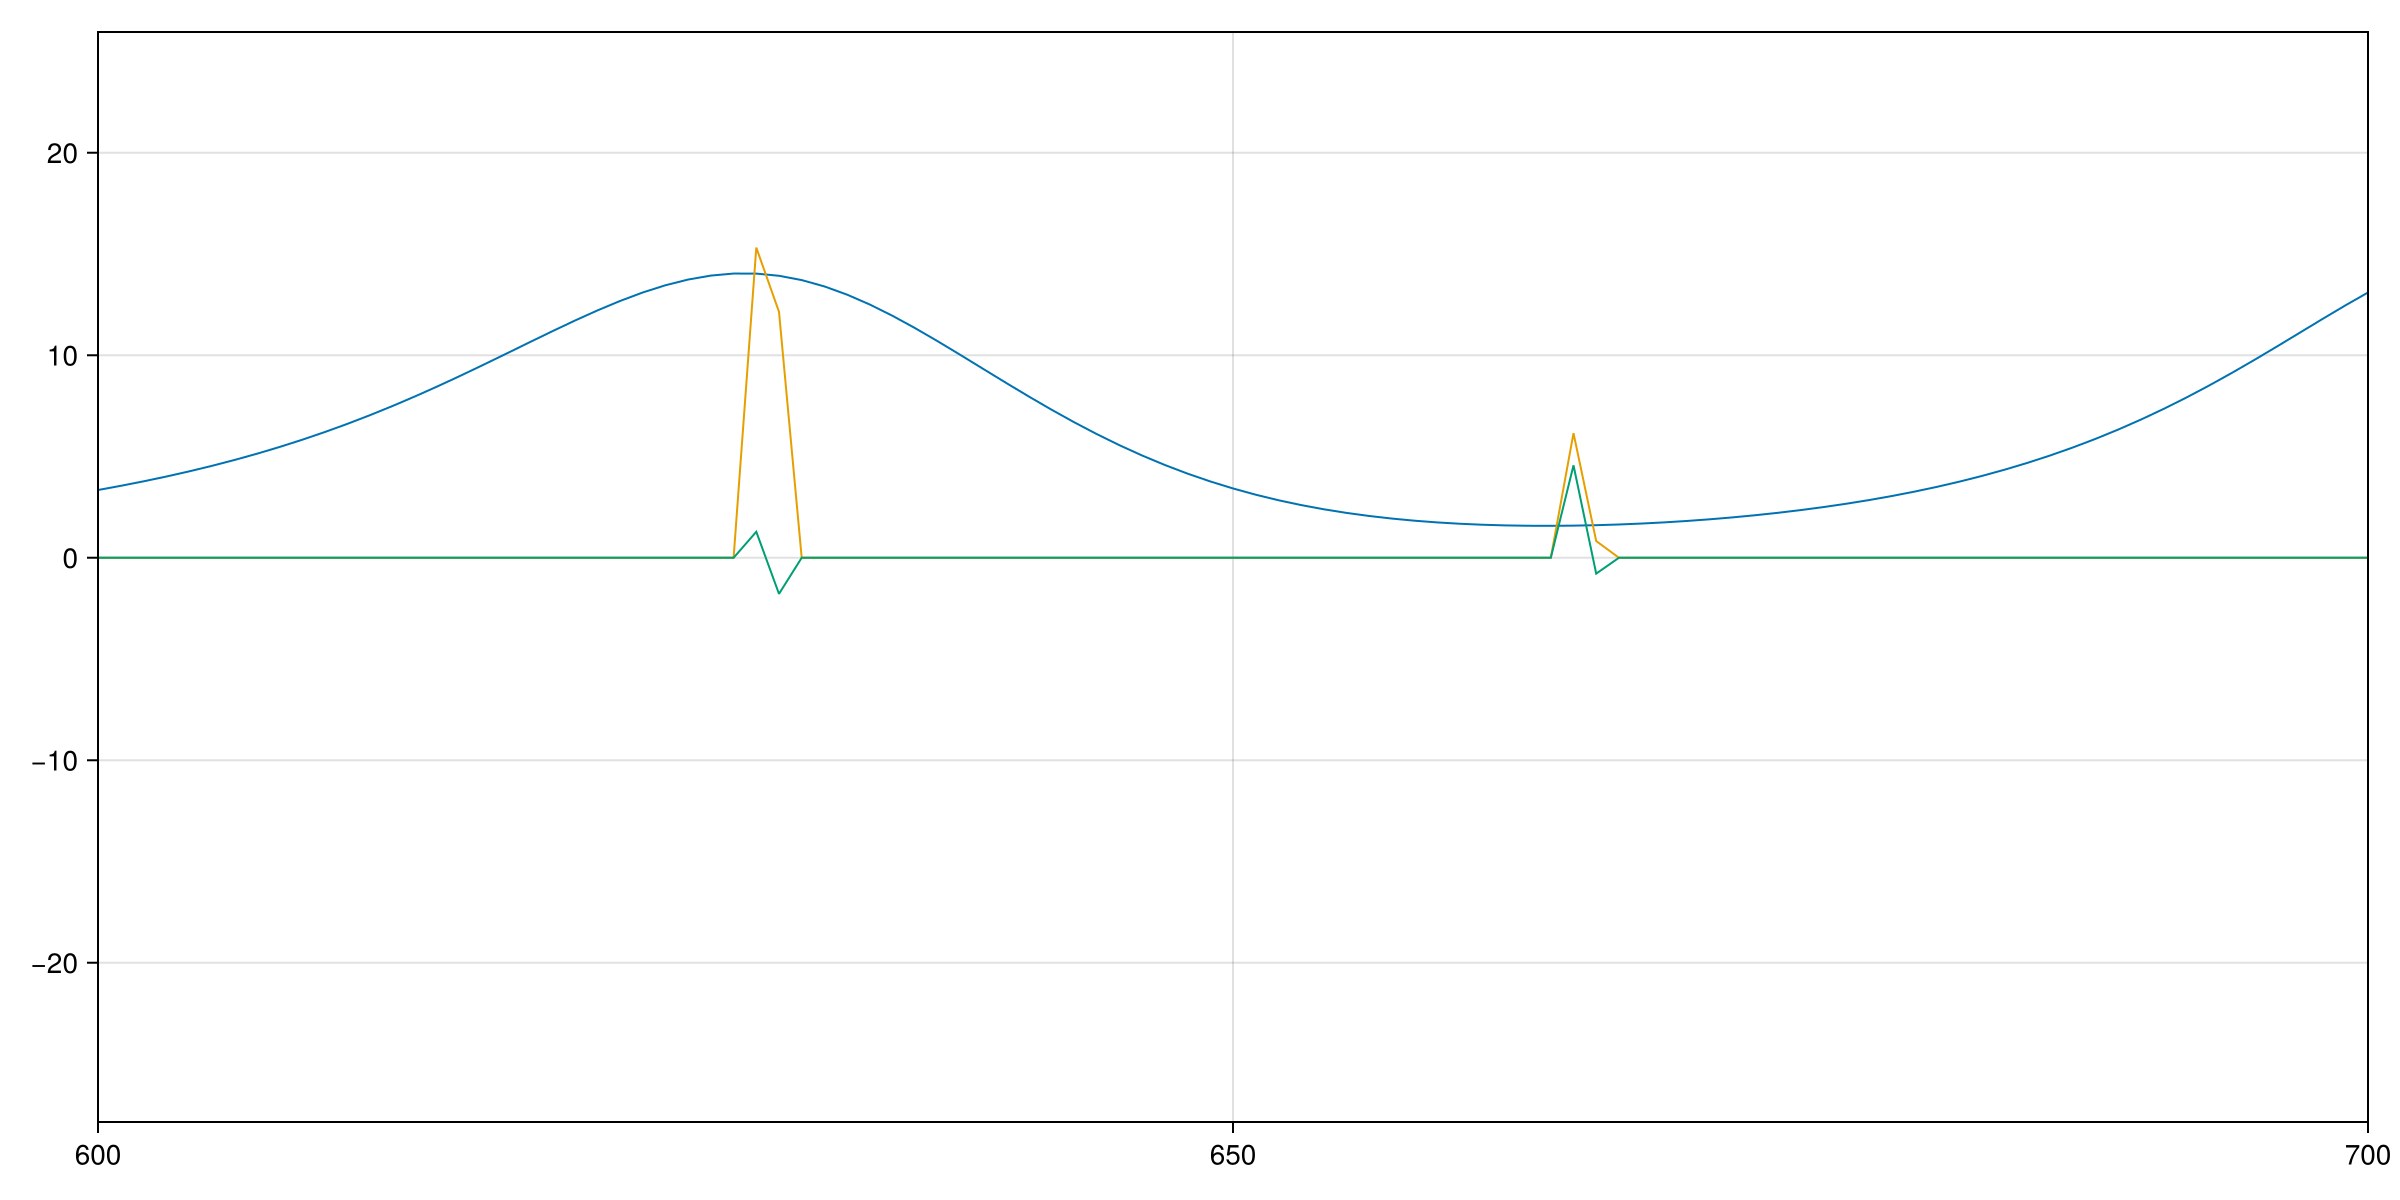

In [8]:
test_preds = lo_test + 3 * randn(length(lo_test))

test_mask = create_turning_partition_mask(lo_test, 4, 1, 1)
error = test_preds .- lo_test

fig = Figure( size = (1200,600))

ax1 = Axis(fig[1,1])
lines!(ax1, lo_test; linewidth = 1.0, color = Cycled(1))
lines!(ax1, test_preds .* test_mask; linewidth = 1.0, color = Cycled(2))
lines!(ax1, error .* test_mask; linewidth = 1.0, color = Cycled(3))

xlims!(600,700)

fig

# Single step predictions

### Equal size of overall reservoir

#### 600 total size

Created reservoir of size: (600,)


Created reservoir of size: (600,)


Overall RMSE:
    Vanilla: 0.4329262892938109
    Ordinal network reservoir: 0.4329126681165609
Turning partition RMSE:
    Vanilla: 0.3318739090138404
    Ordinal network reservoir: 0.334865120146528


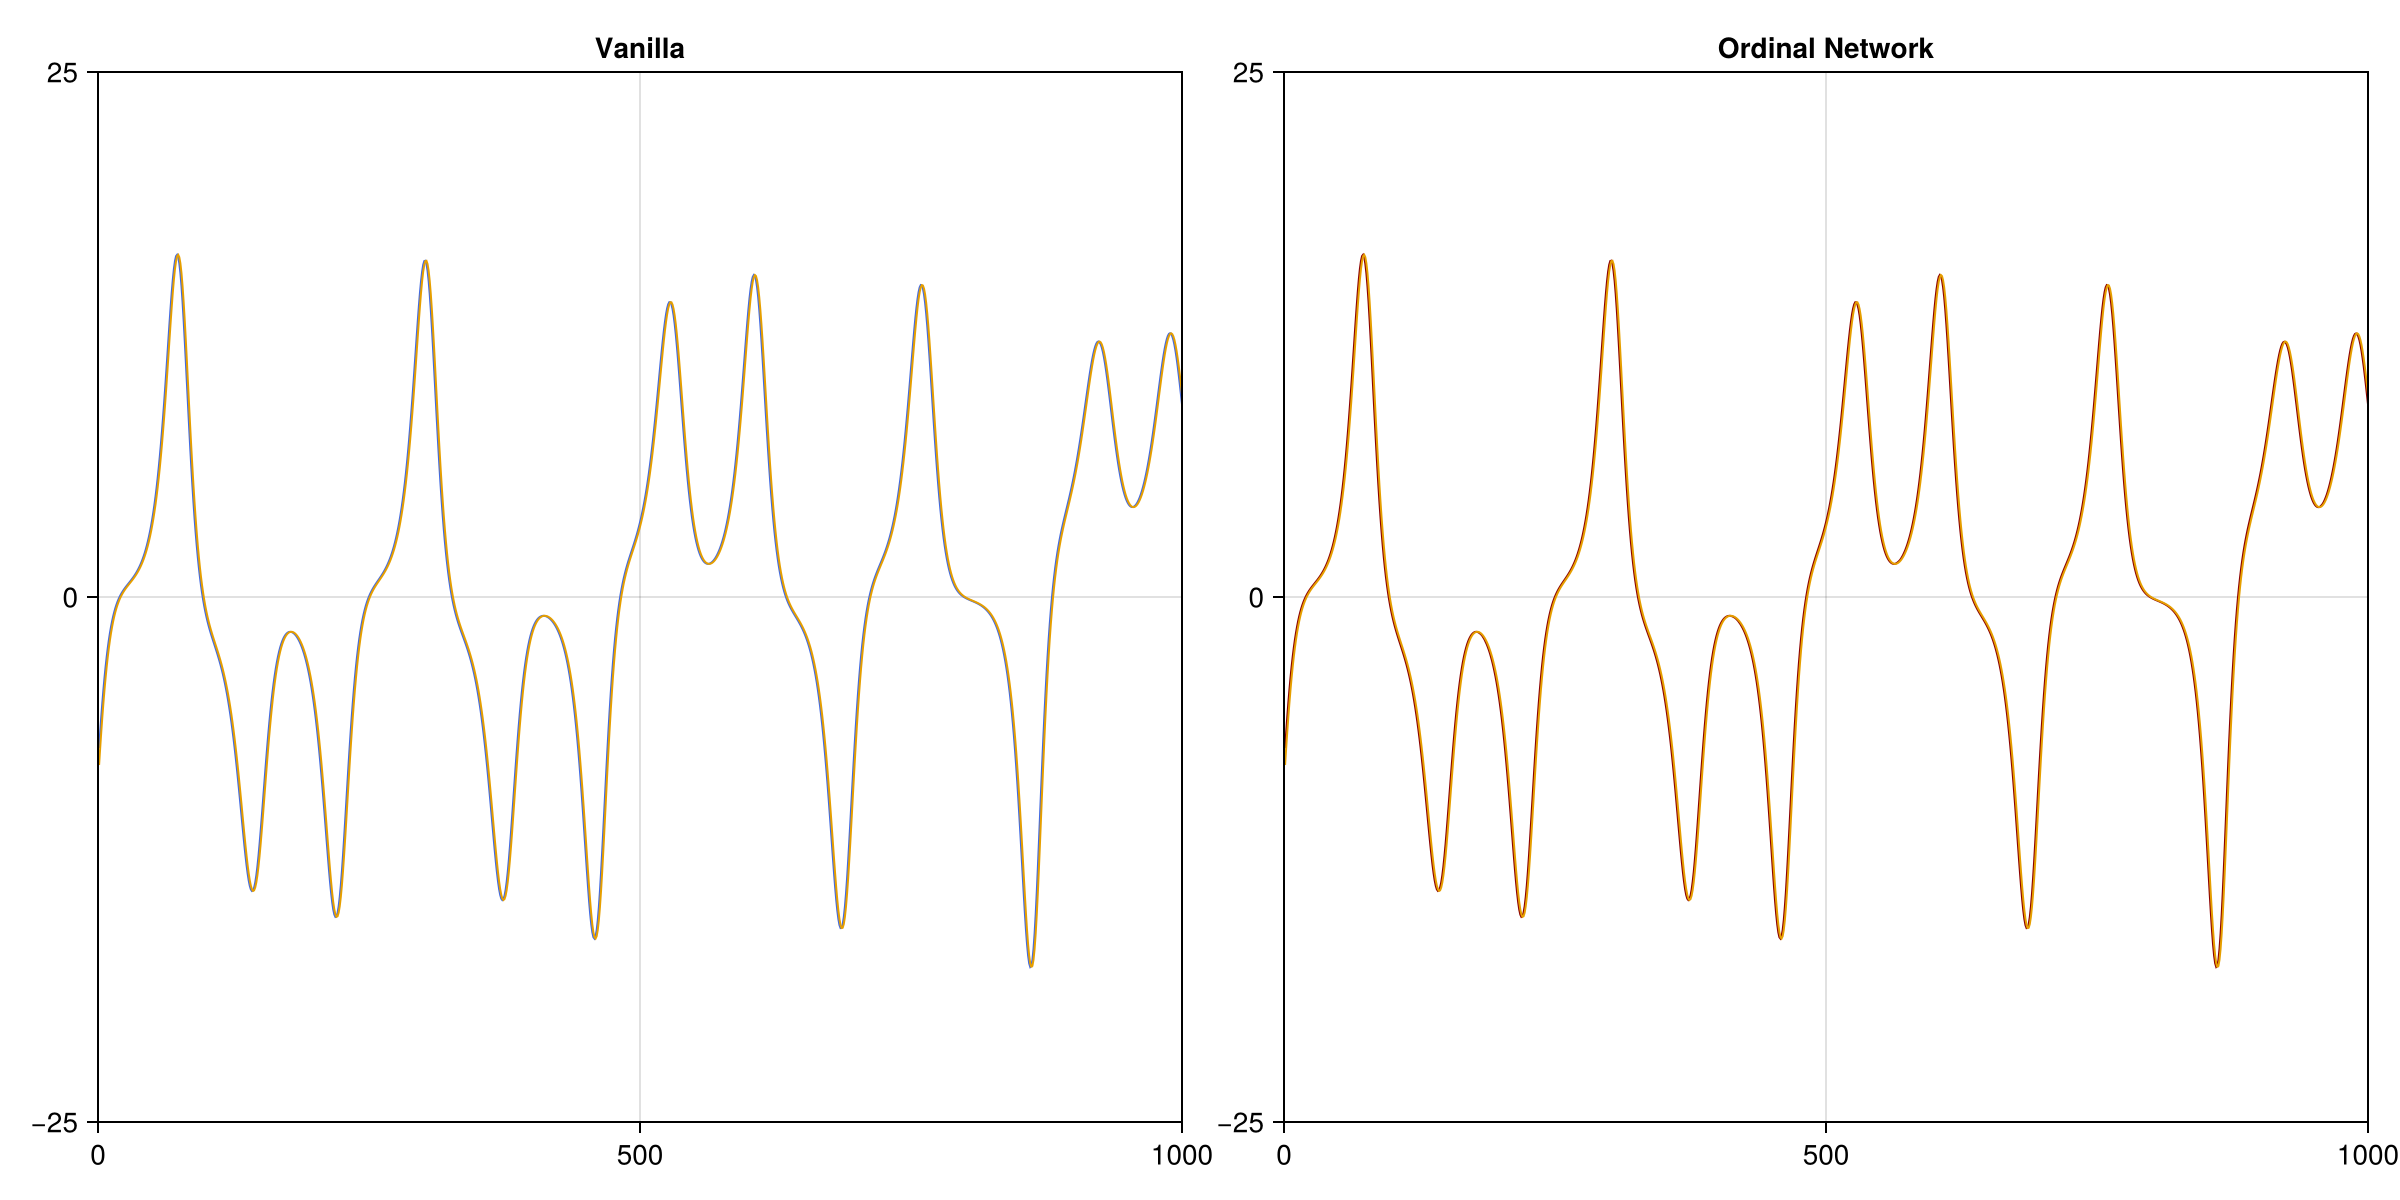

In [9]:
test_single_step(lo_train, lo_test, 3, 100; from=0, to=1000, ignore_first=100)

Created reservoir of size: (300,)


Created reservoir of size: (300,)


Overall RMSE:
    Vanilla: 0.43301339910836906
    Ordinal network reservoir: 0.43289879016430033
Turning partition RMSE:
    Vanilla: 0.33195399501180484
    Ordinal network reservoir: 0.3337189981323074


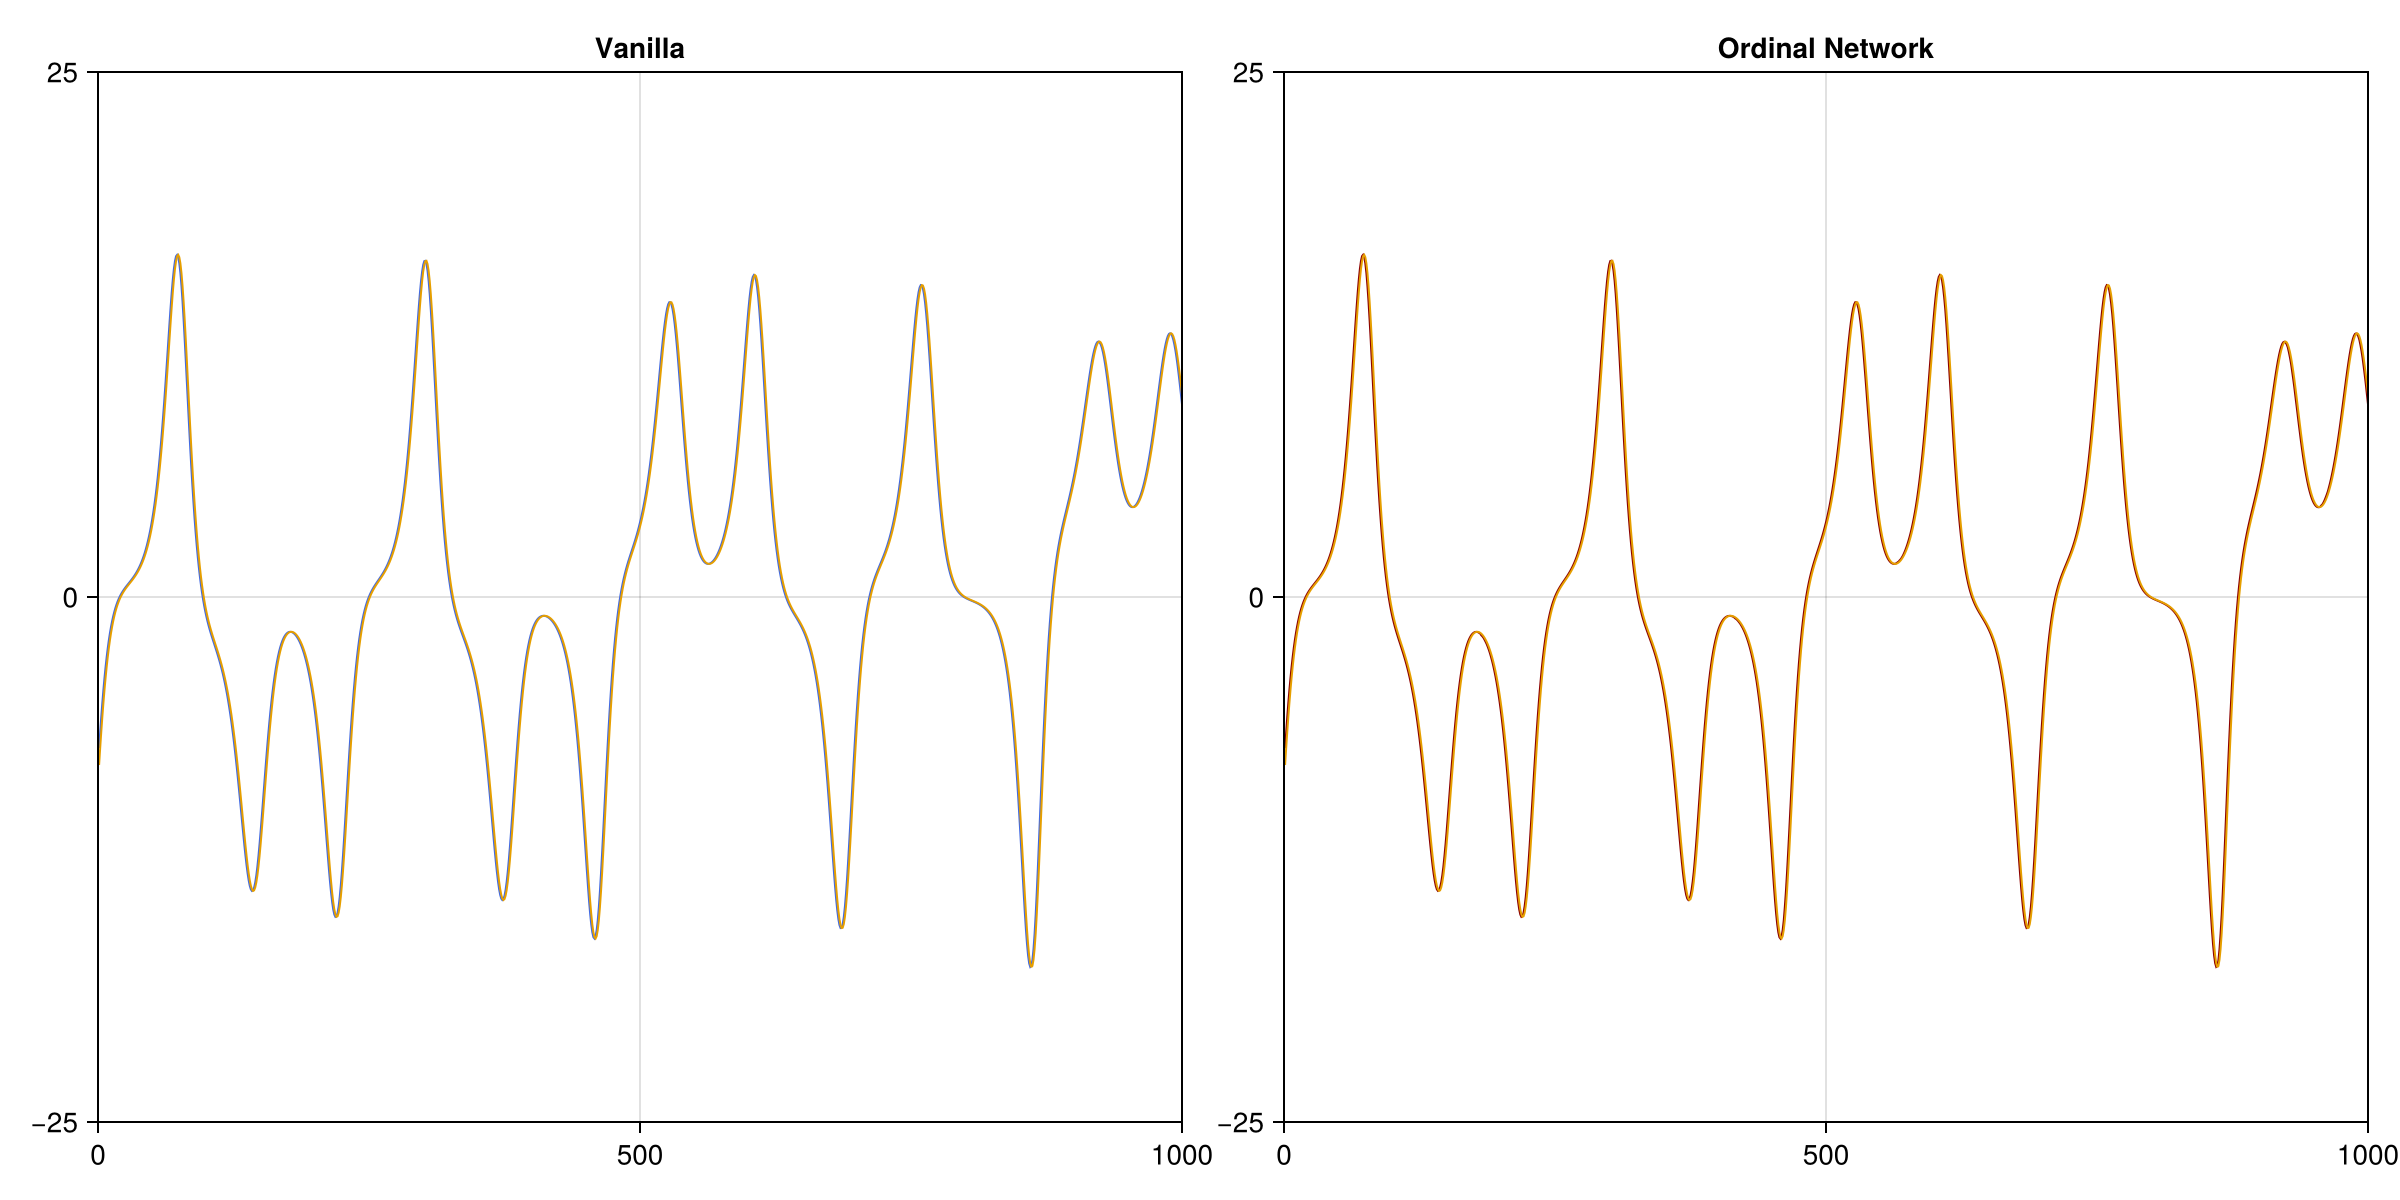

In [10]:
test_single_step(lo_train, lo_test, 3, 50; from=0, to=1000, ignore_first=100)

Created reservoir of size: (1200,)


Created reservoir of size: (1200,)


Overall RMSE:
    Vanilla: 0.43297021603319963
    Ordinal network reservoir: 0.4330223777172834
Turning partition RMSE:
    Vanilla: 0.33178989415954846
    Ordinal network reservoir: 0.3336581141109376


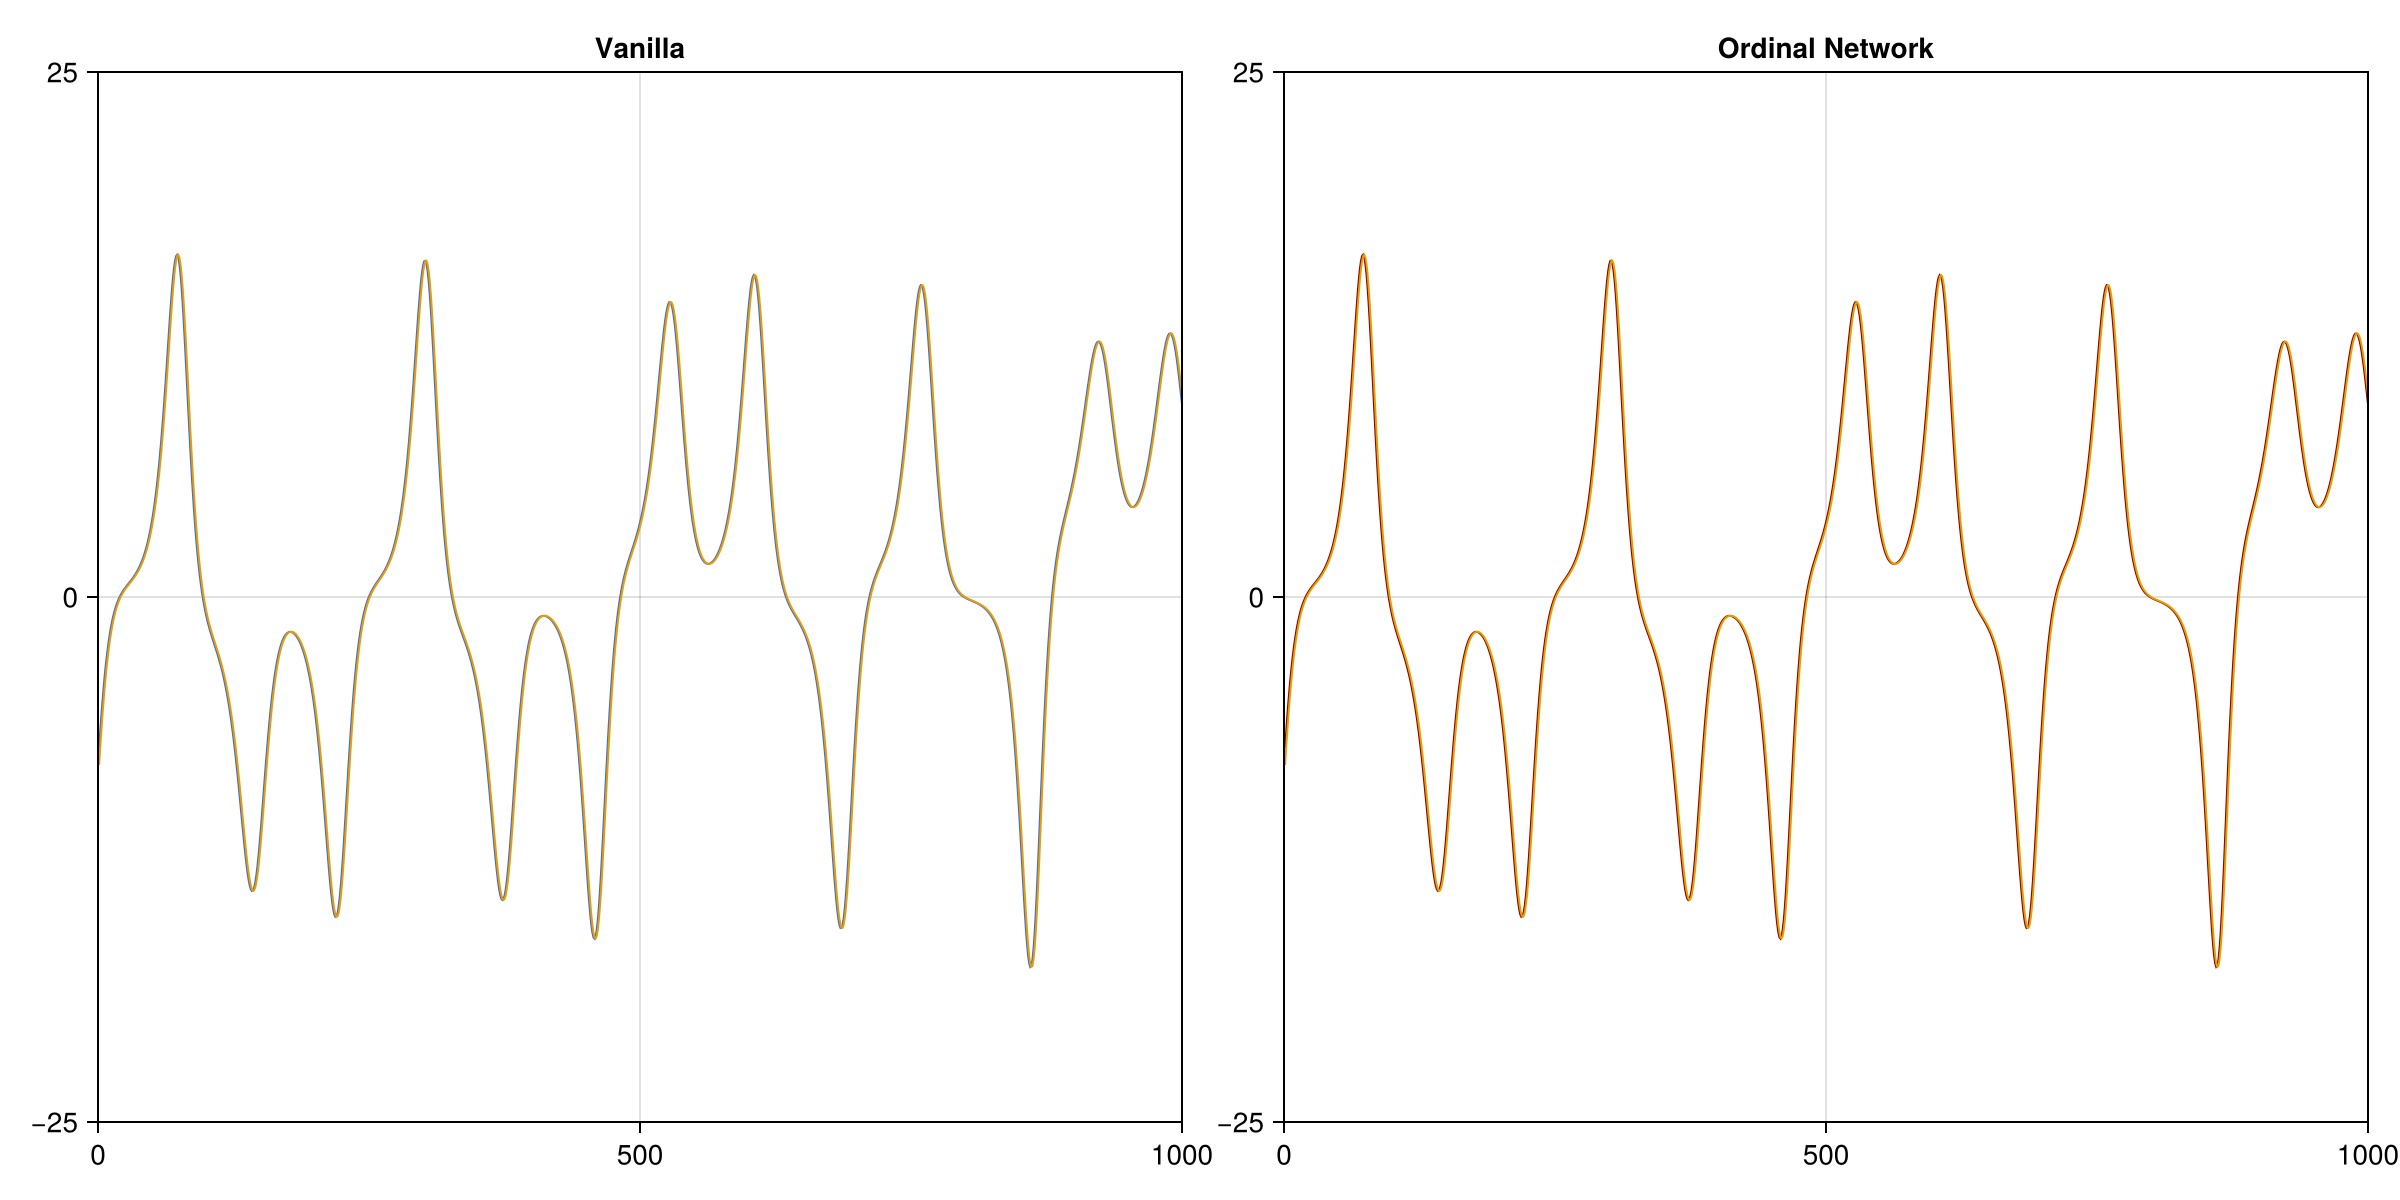

In [11]:
test_single_step(lo_train, lo_test, 3, 200; from=0, to=1000, ignore_first=100)

### Equal k

#### k = 100

Created reservoir of size: (600,)


Created reservoir of size: (100,)
Overall RMSE:
    Vanilla: 0.43296844382272975
    Ordinal network reservoir: 0.4329552070991032
Turning partition RMSE:
    Vanilla: 0.33024427560053965
    Ordinal network reservoir: 0.3338809261458445


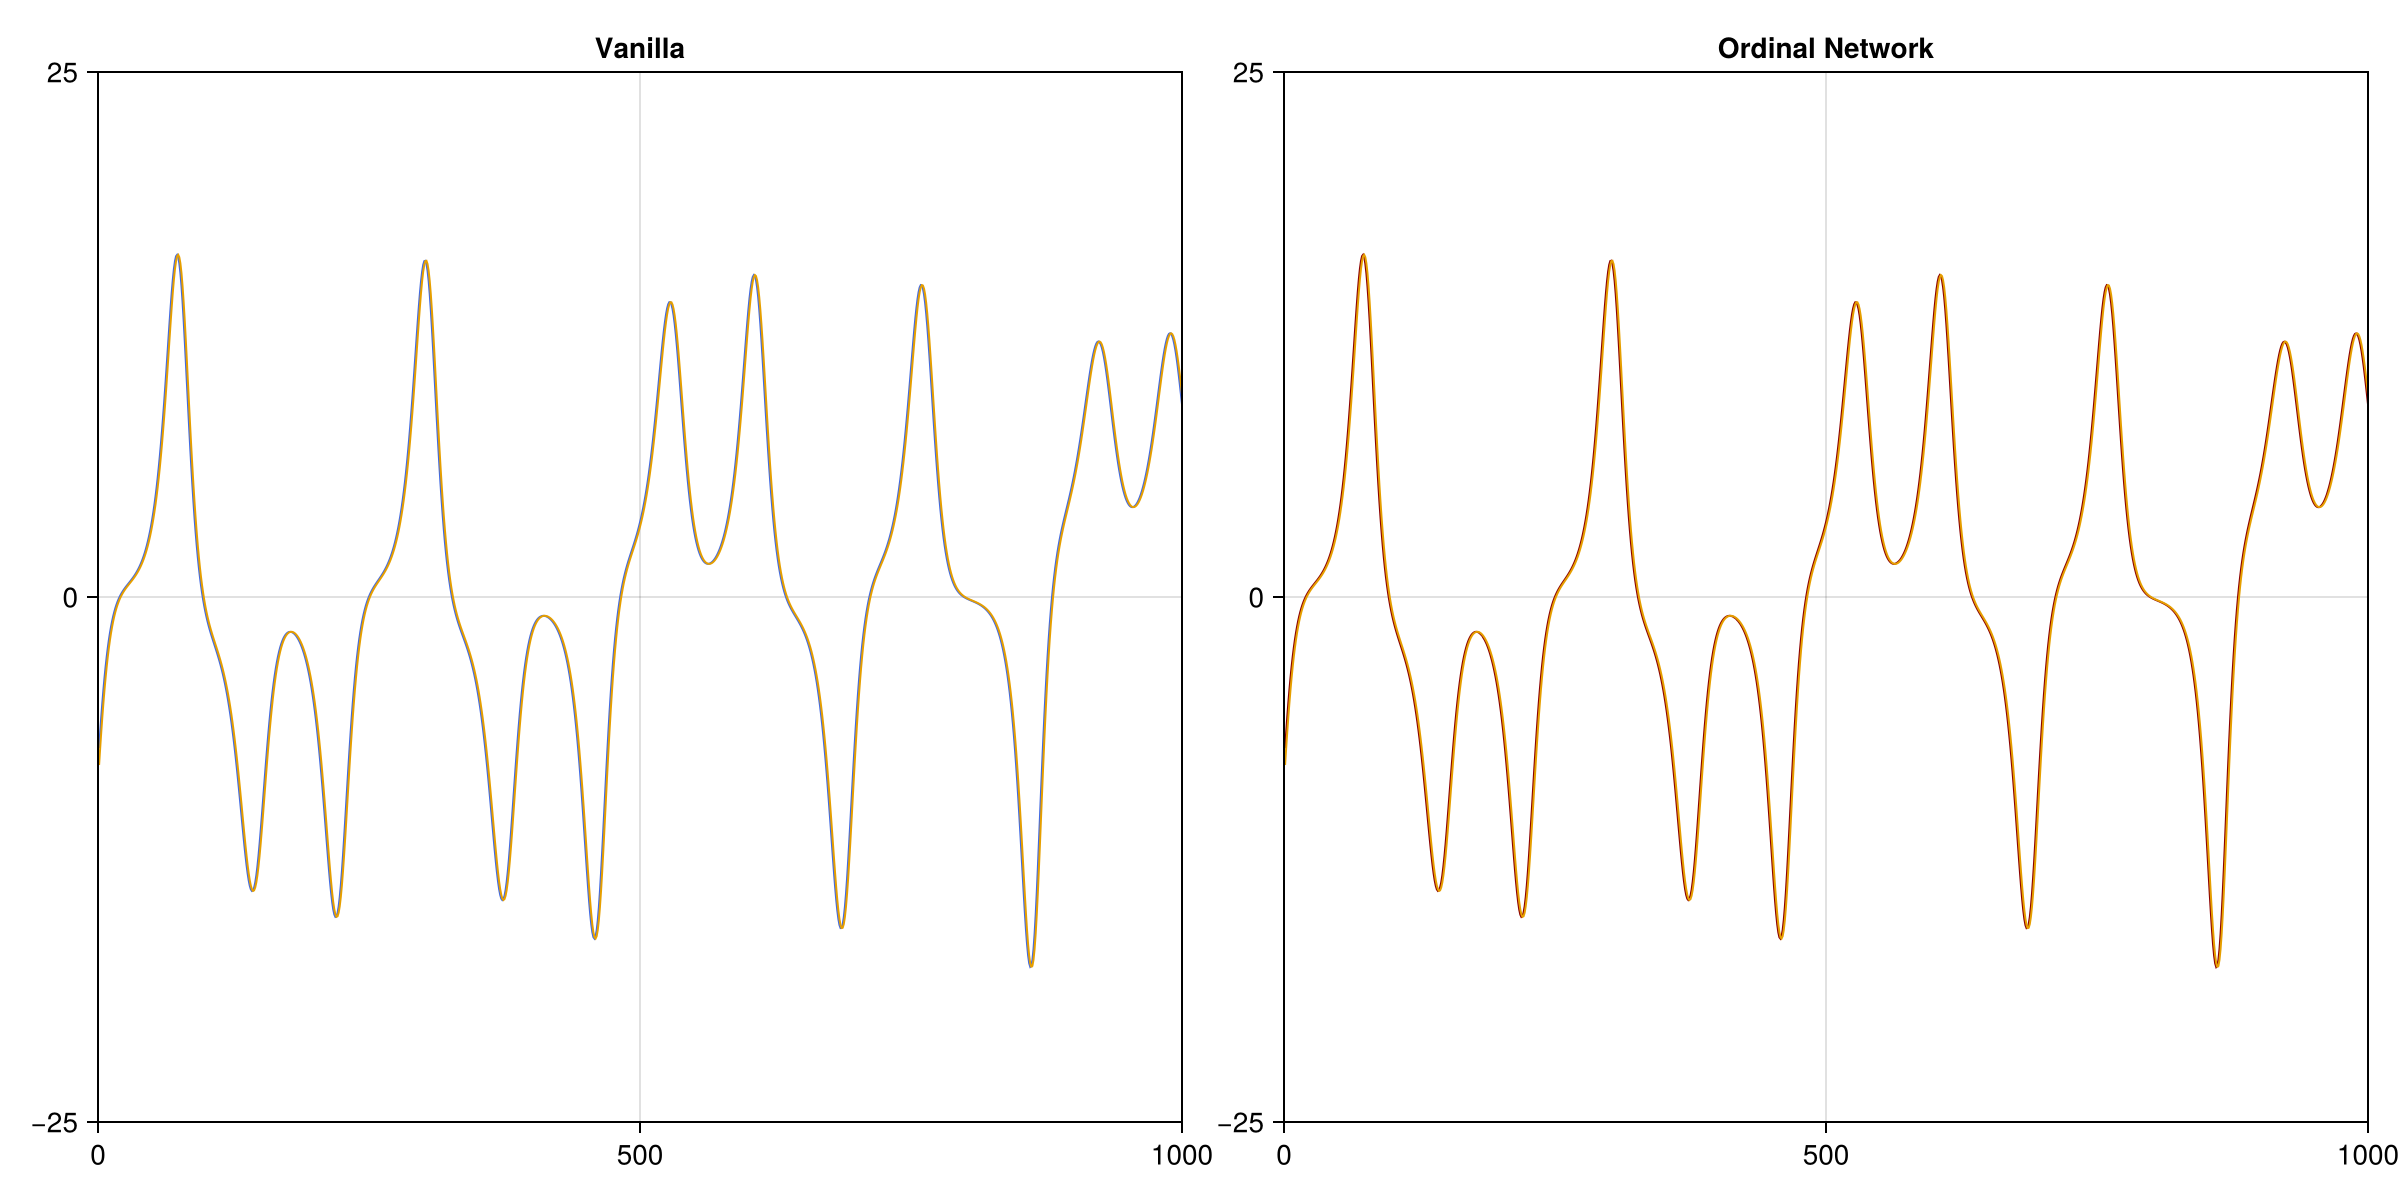

In [12]:
test_single_step(lo_train, lo_test, 3, 100; from=0, to=1000, ignore_first=100, equal_total_k=false)

#### k = 500

Created reservoir of size: (3000,)


Created reservoir of size: (500,)


Overall RMSE:
    Vanilla: 0.4330651874876267
    Ordinal network reservoir: 0.43304284580578506
Turning partition RMSE:
    Vanilla: 0.33174787730877403
    Ordinal network reservoir: 0.33423510615487534


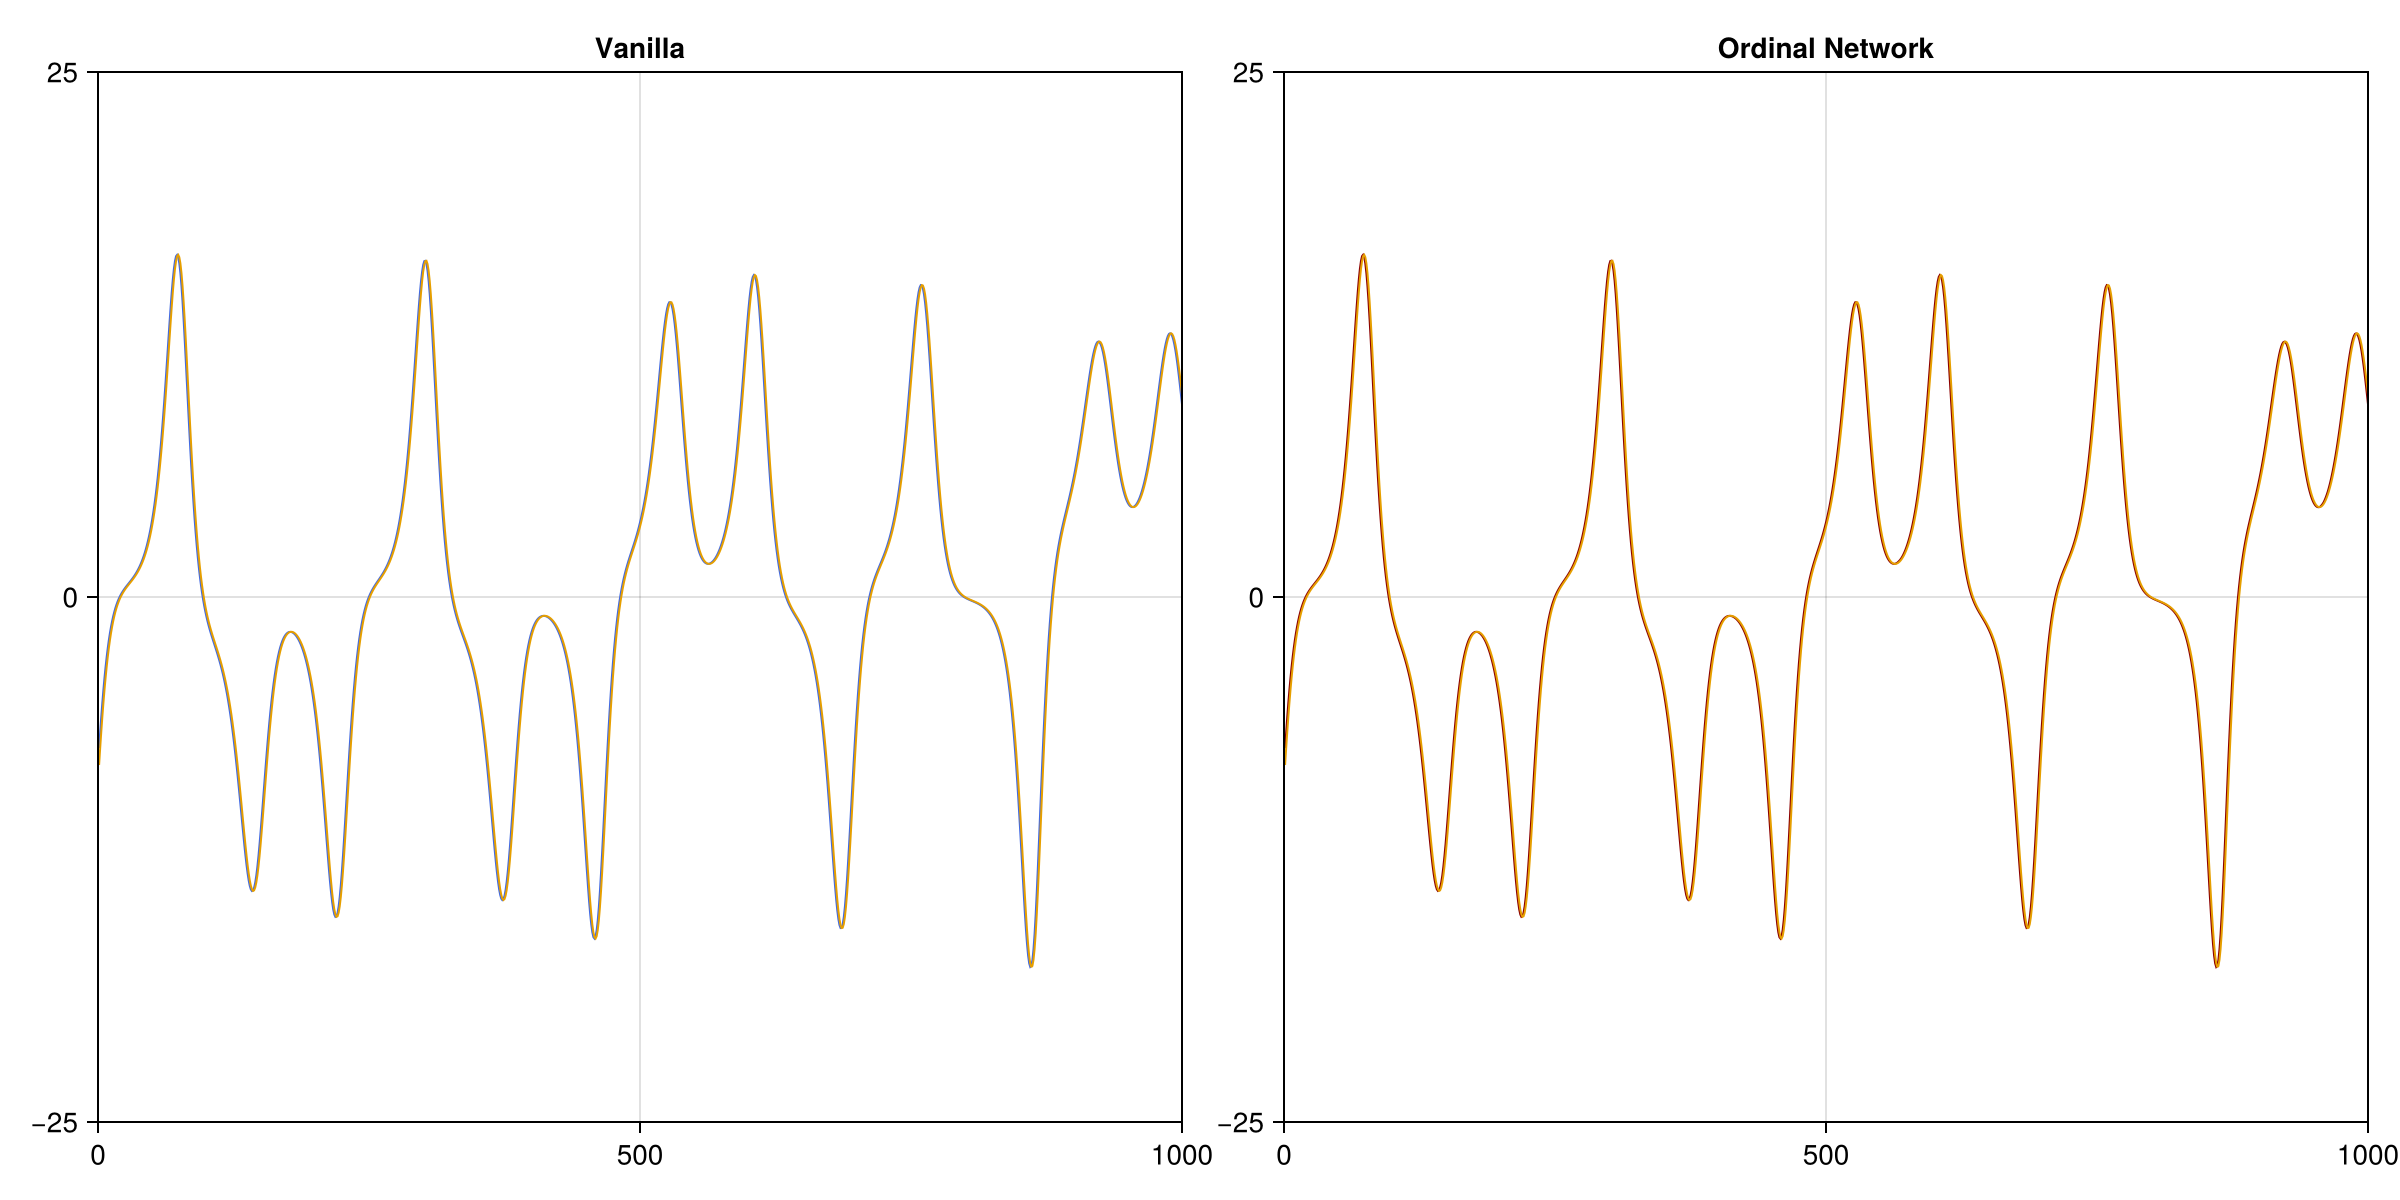

In [13]:
test_single_step(lo_train, lo_test, 3, 500; from=0, to=1000, ignore_first=100, equal_total_k=false)

# Freerun predictions

Created reservoir of size: (390,)


Created reservoir of size: (390,)


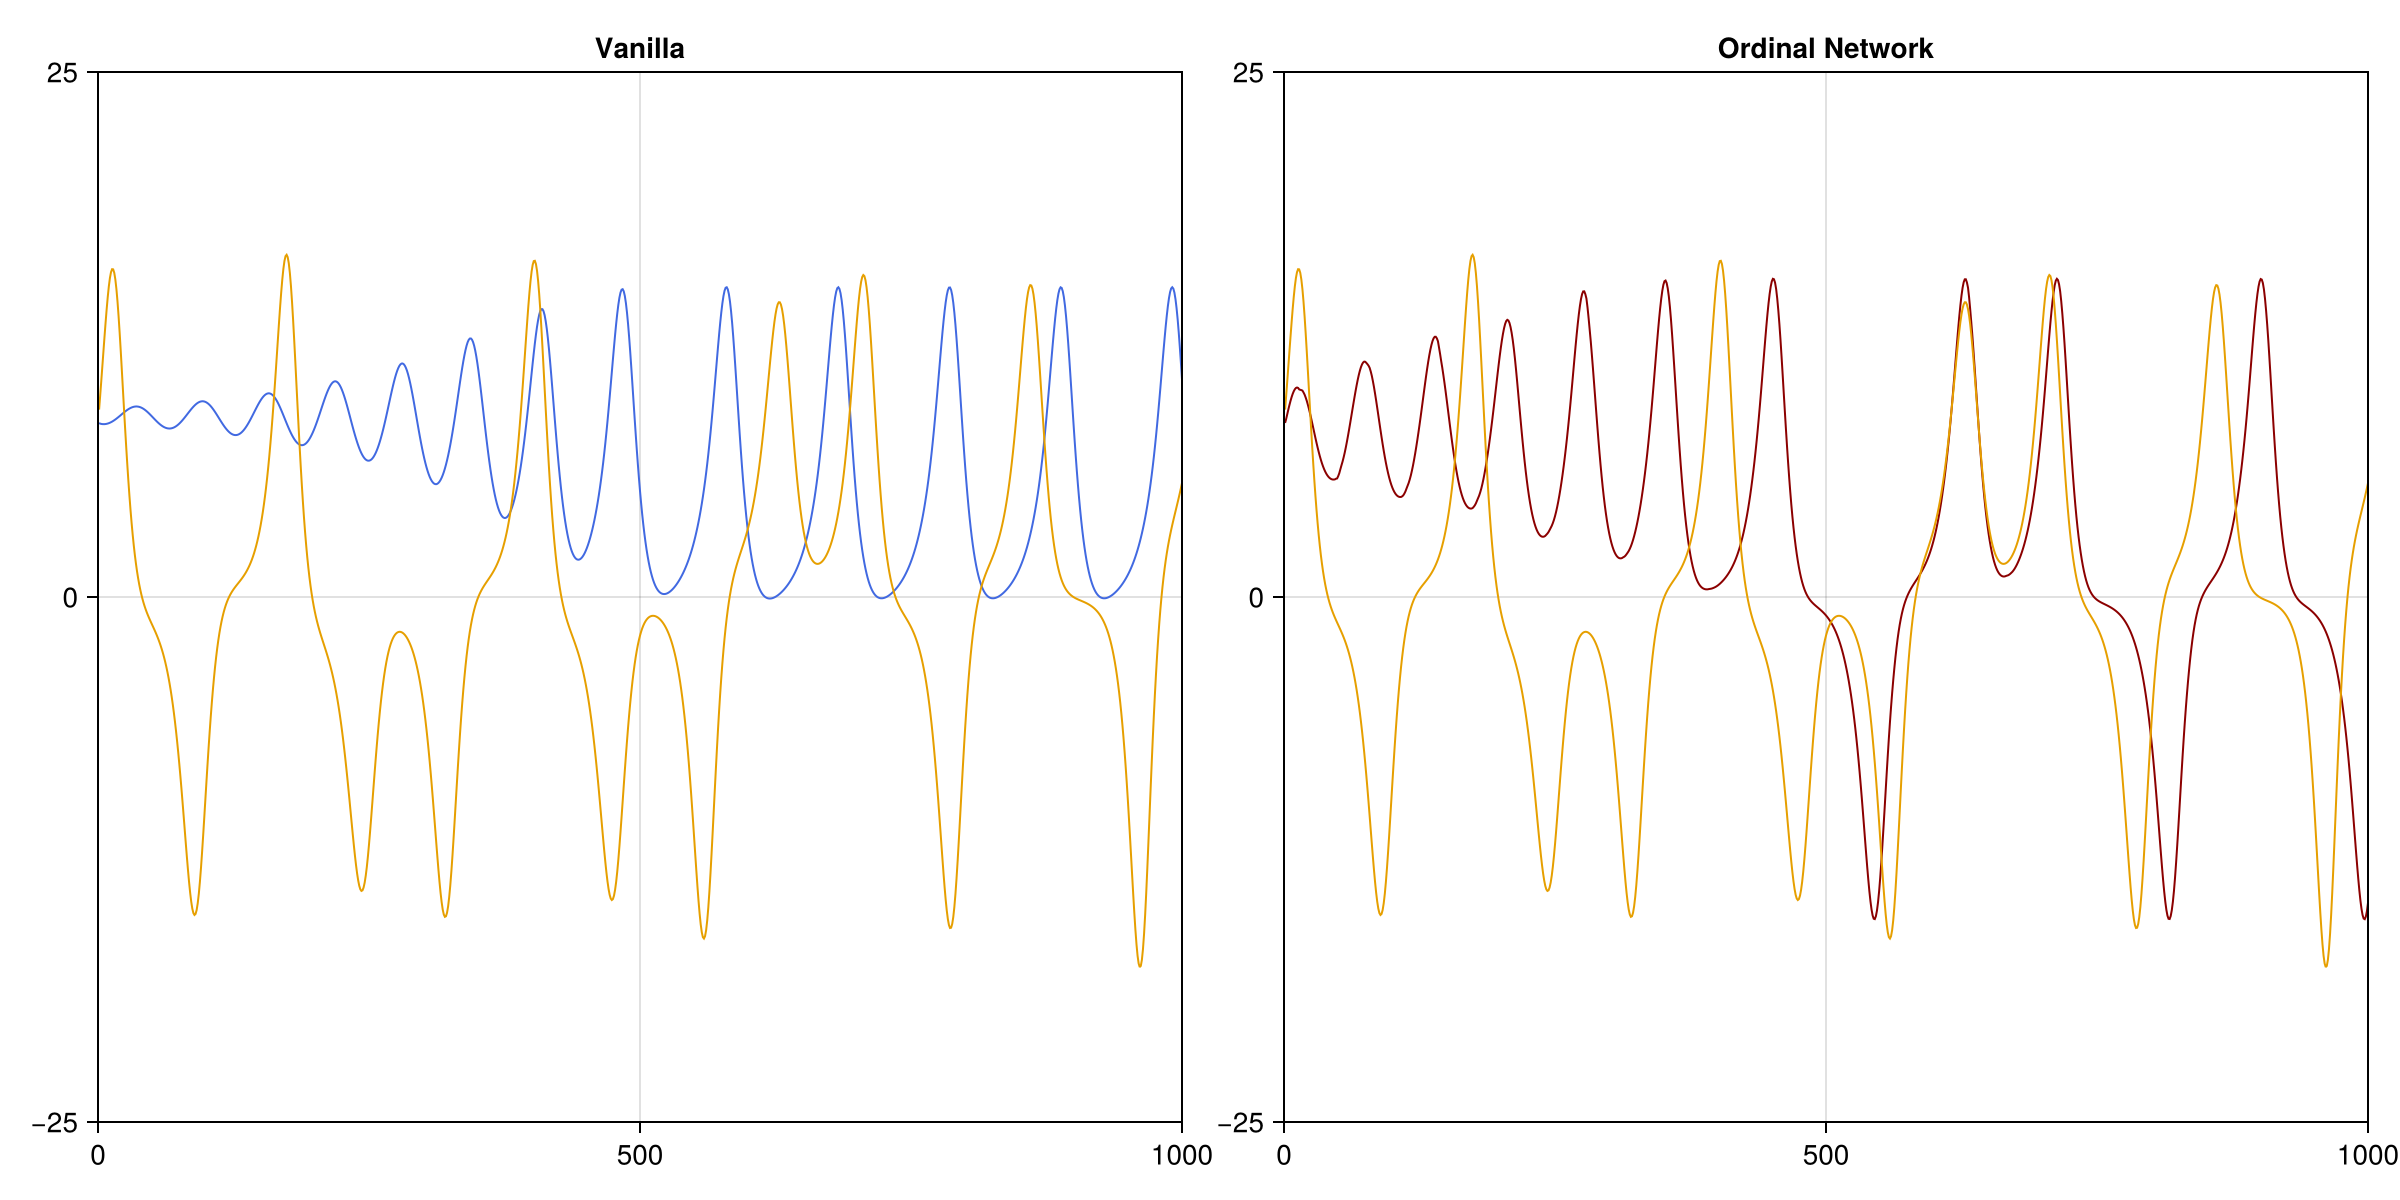

In [14]:
test_freerun(lo_train, lo_test, 4, 30; from=0, to=1000)

# Multi step predictions

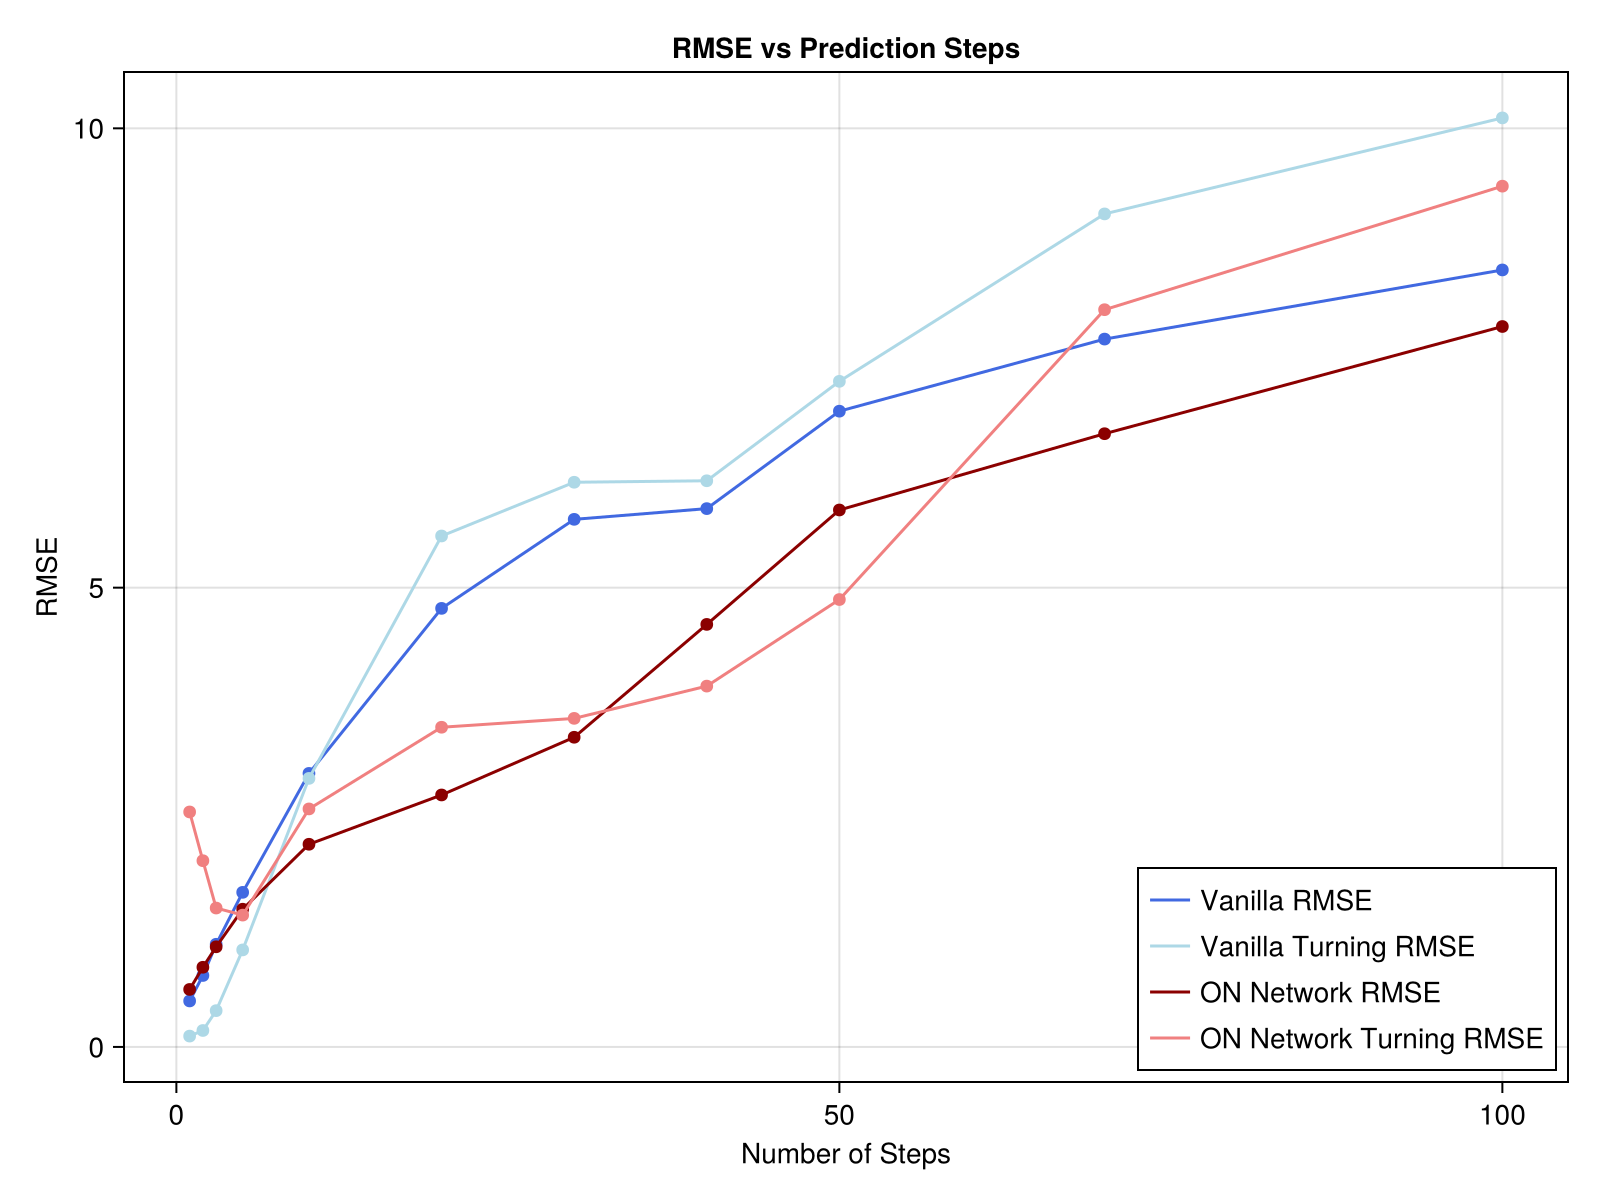

In [15]:
graph_multi_step_RMSE_vs_n_steps(lo_train, lo_test, [1, 2, 3, 5, 10, 20, 30, 40, 50, 70, 100], 3, 50; ignore_first=100, trials=30)

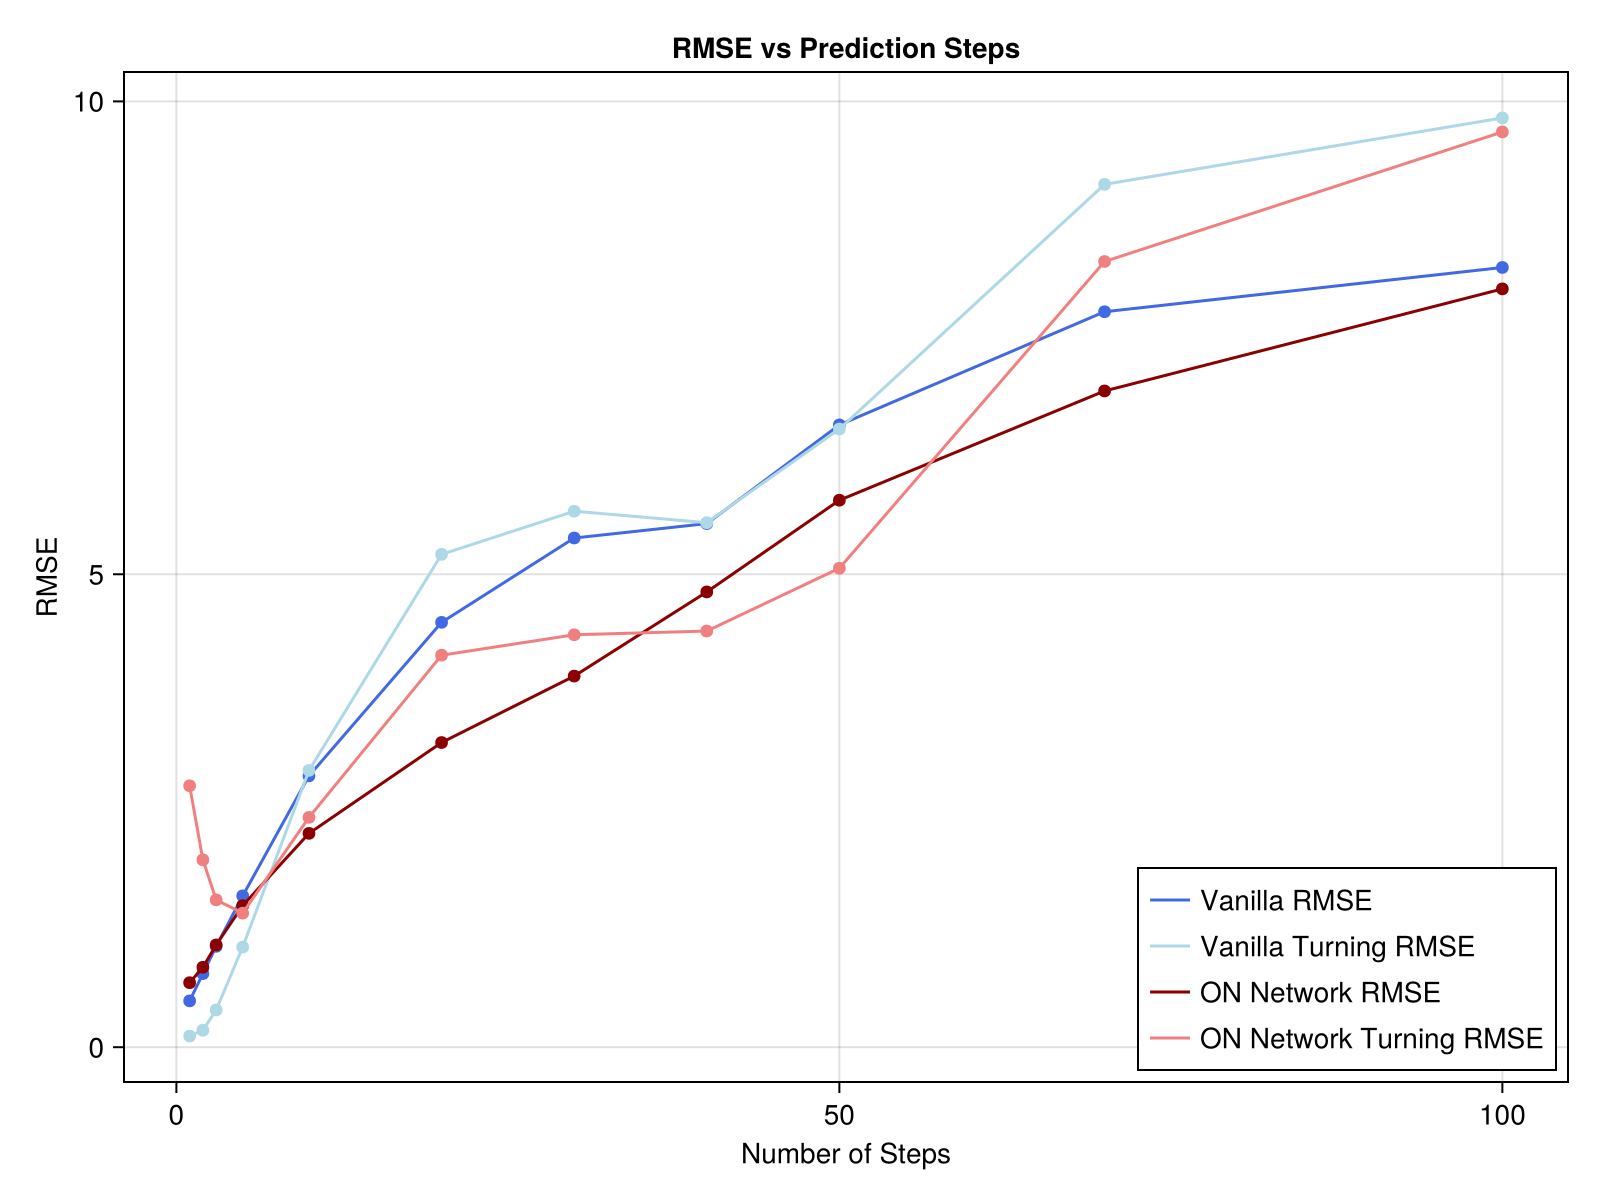

In [16]:
graph_multi_step_RMSE_vs_n_steps(lo_train, lo_test, [1, 2, 3, 5, 10, 20, 30, 40, 50, 70, 100], 3, 100; ignore_first=100, trials=30)

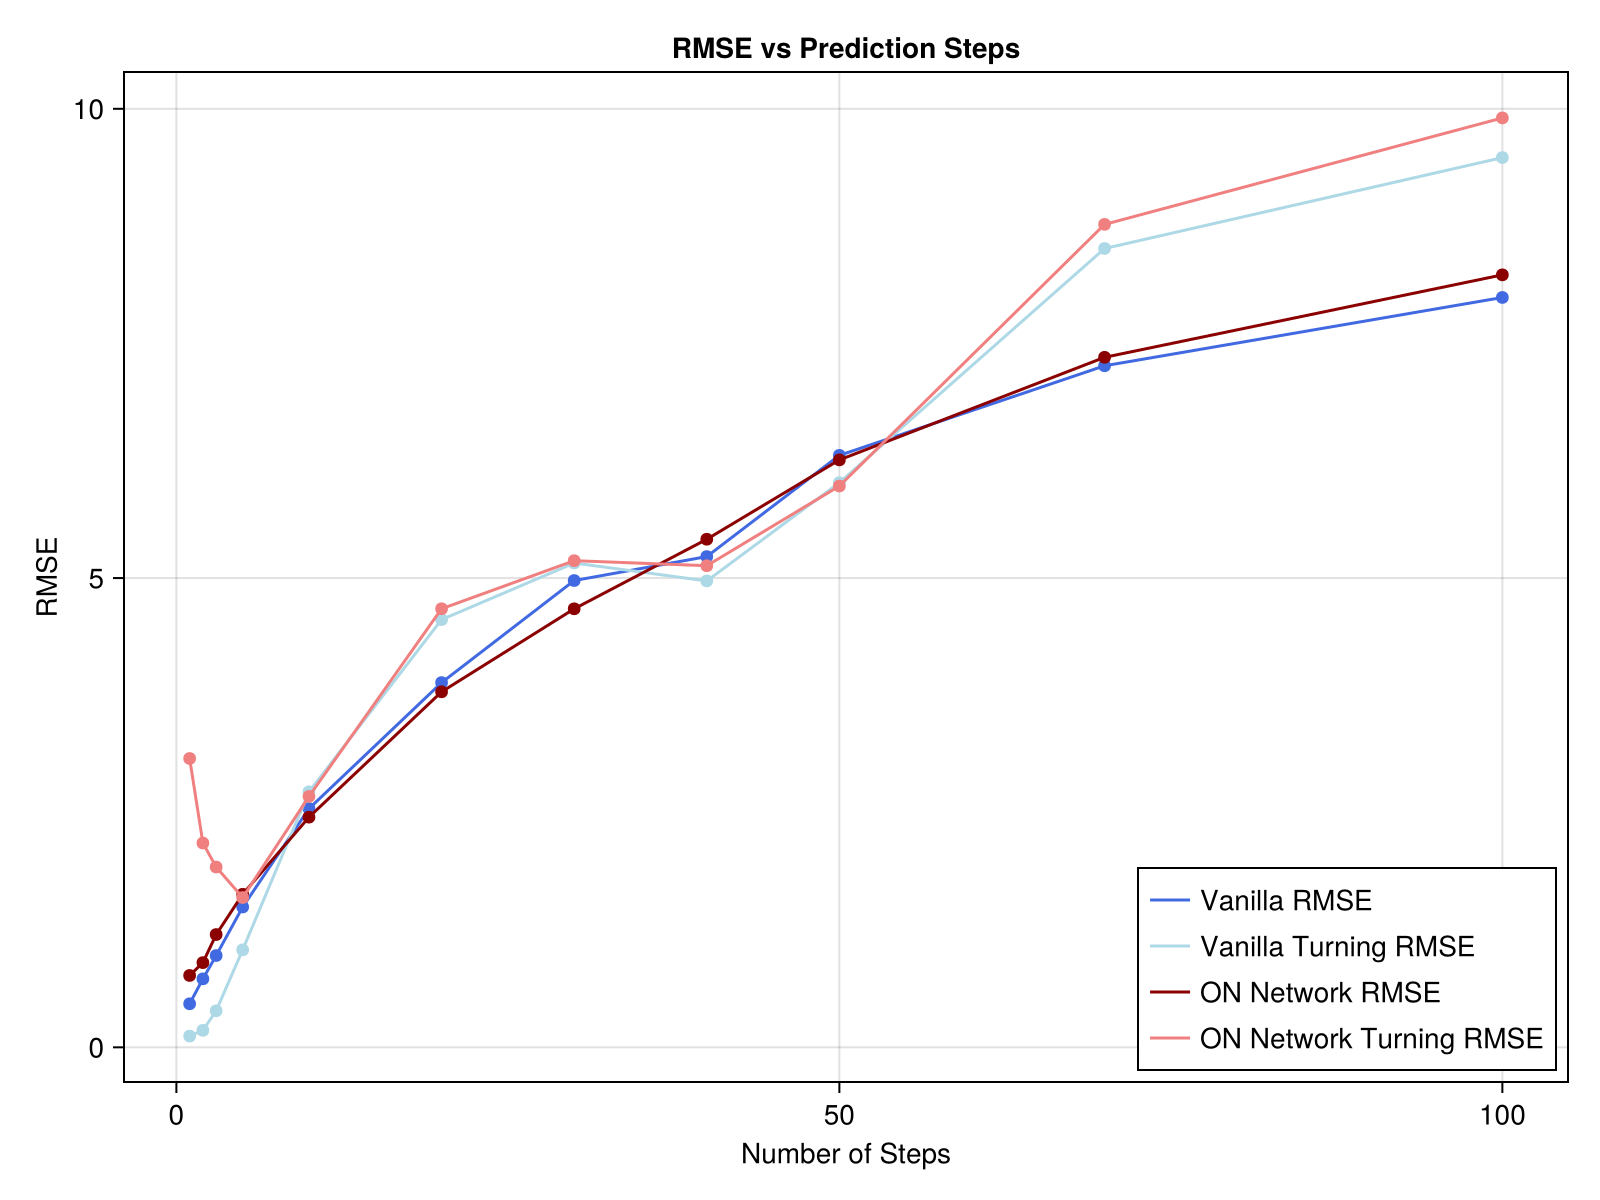

In [17]:
graph_multi_step_RMSE_vs_n_steps(lo_train, lo_test, [1, 2, 3, 5, 10, 20, 30, 40, 50, 70, 100], 3, 300; ignore_first=100, trials=30)

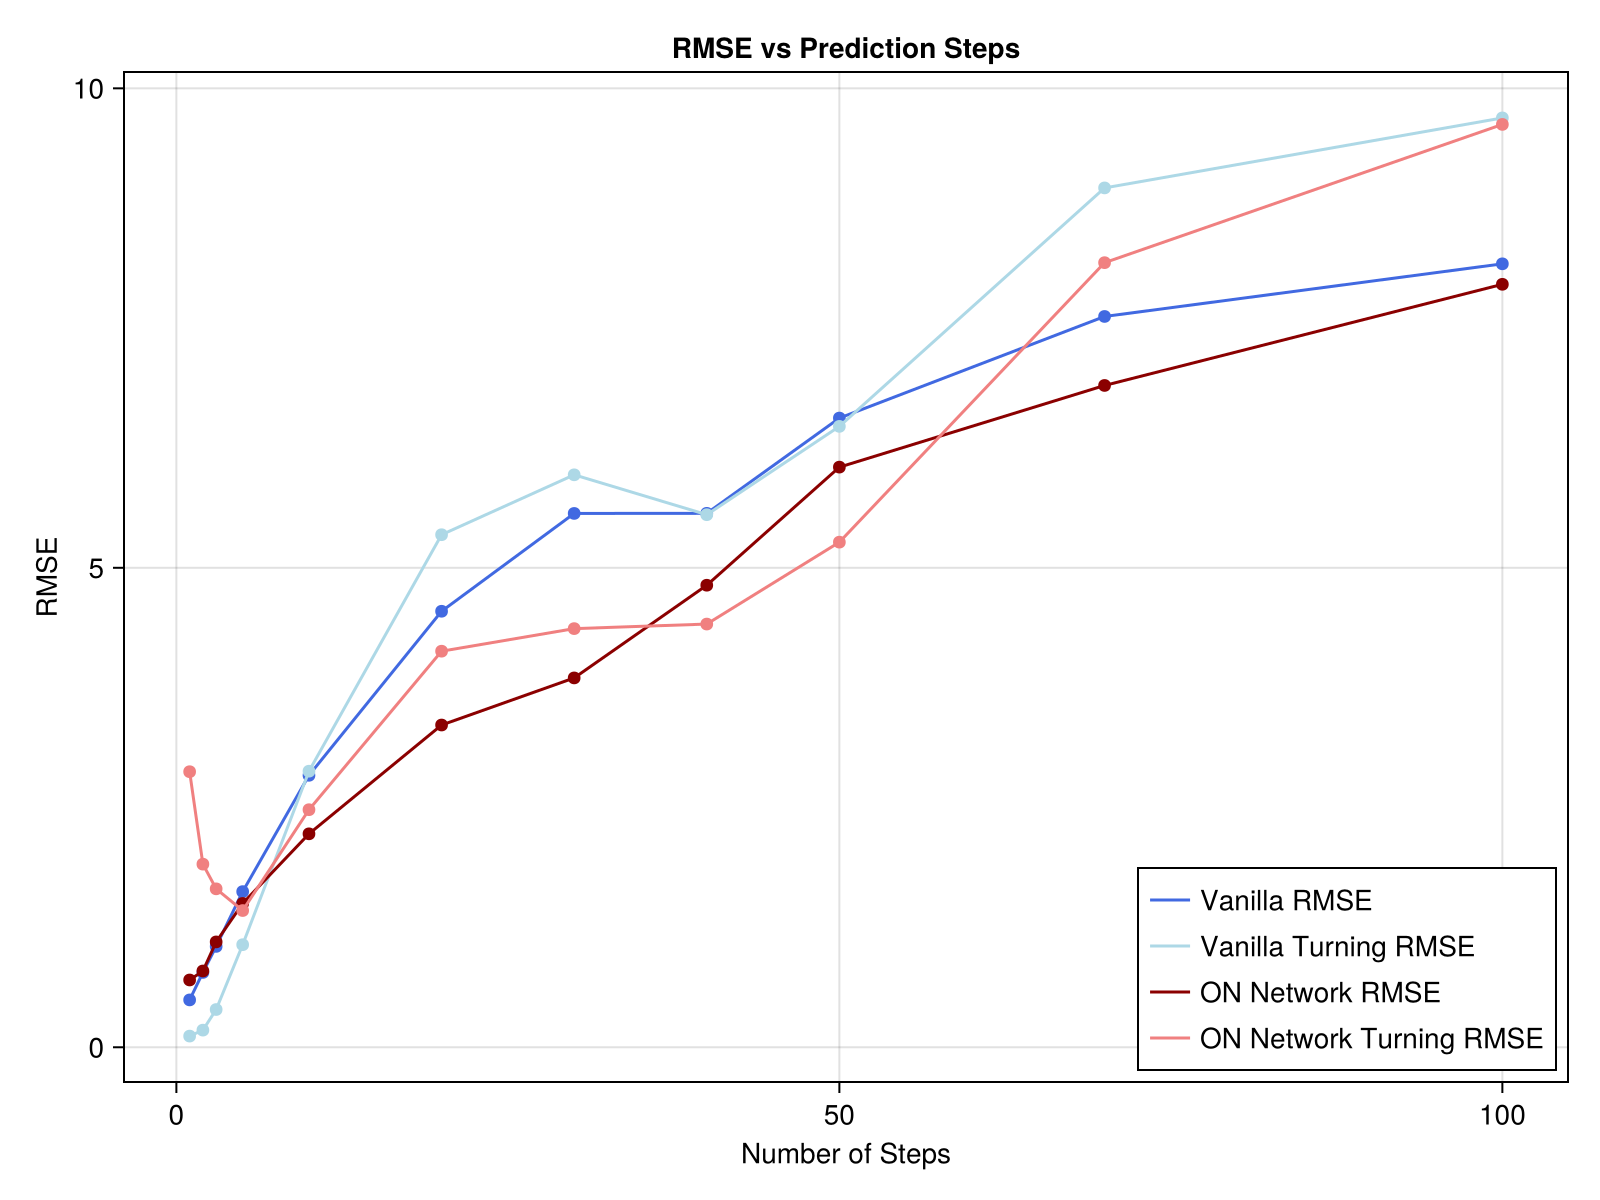

In [18]:
graph_multi_step_RMSE_vs_n_steps(lo_train, lo_test, [1, 2, 3, 5, 10, 20, 30, 40, 50, 70, 100], 4, 100; ignore_first=100, trials=30)

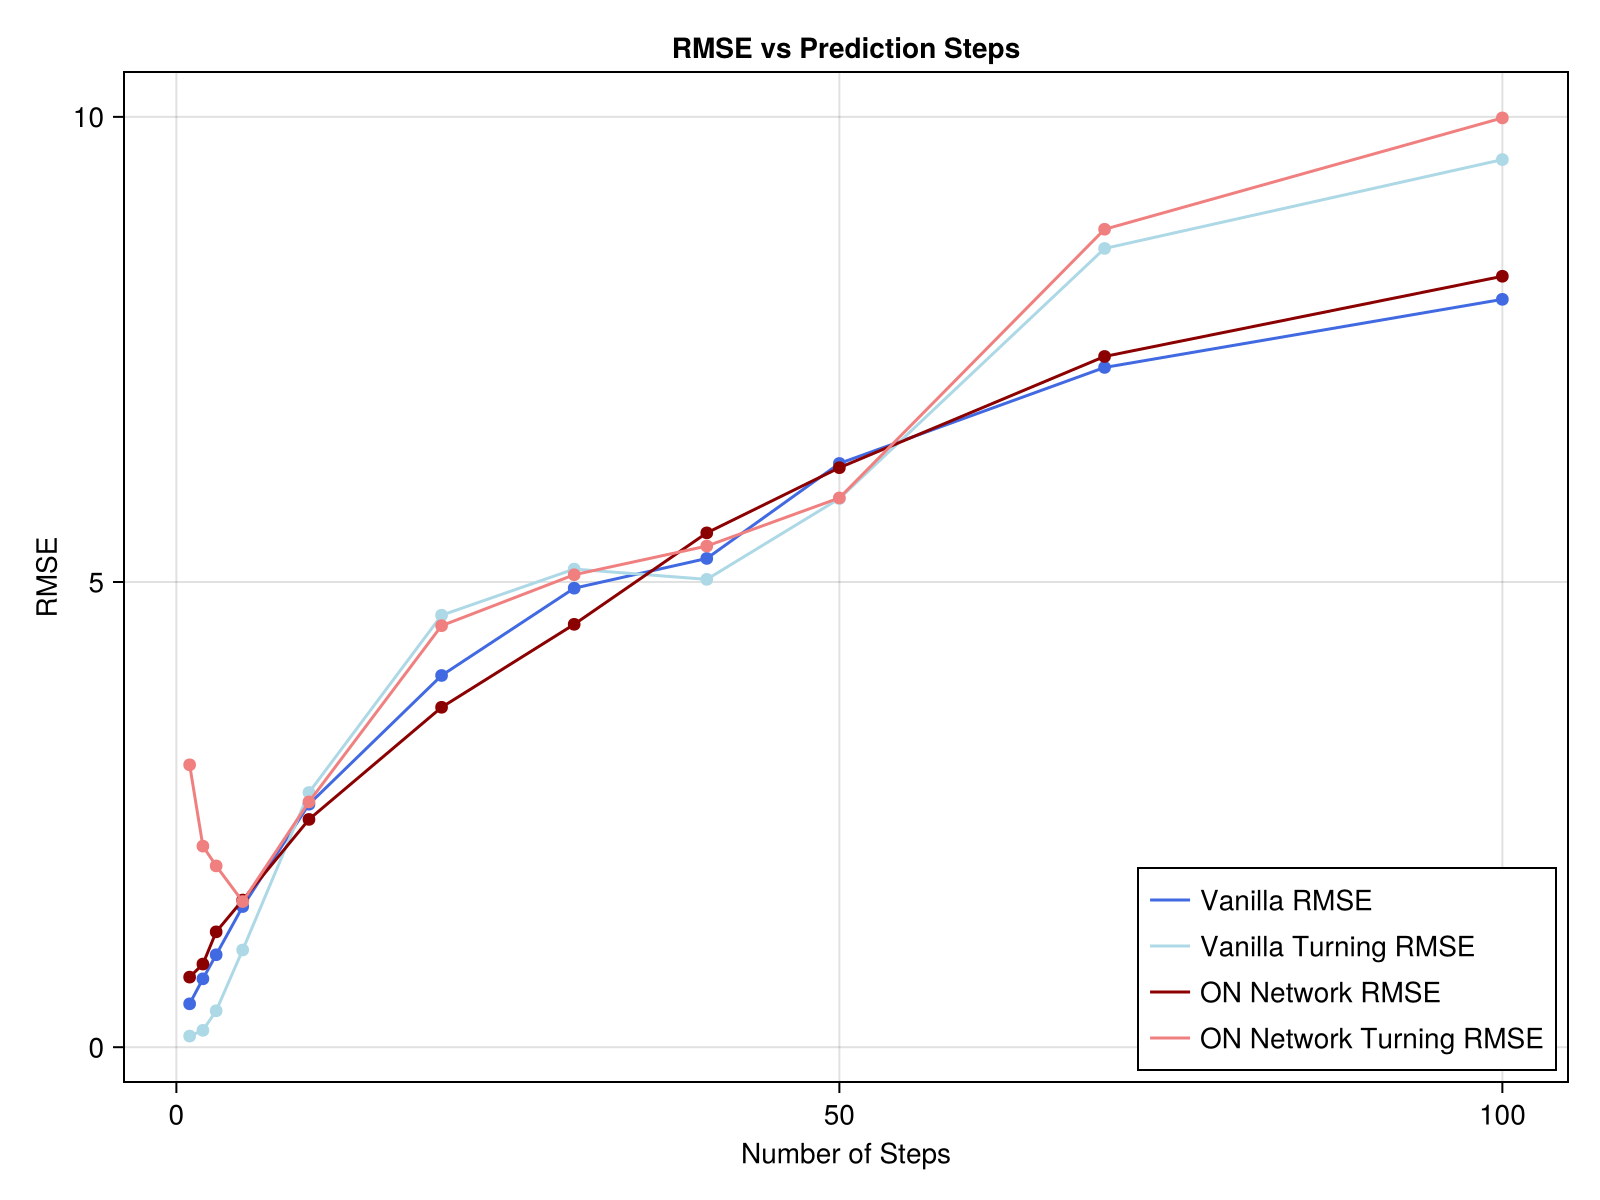

In [19]:
graph_multi_step_RMSE_vs_n_steps(lo_train, lo_test, [1, 2, 3, 5, 10, 20, 30, 40, 50, 70, 100], 4, 250; ignore_first=100, trials=30)

Created reservoir of size: (600,)


Created reservoir of size: (600,)


Overall RMSE:
    Vanilla: 6.0286121479729395
    Ordinal network reservoir: 7.753602748653324
Turning partition RMSE:
    Vanilla: 4.8126326088754245
    Ordinal network reservoir: 8.895123913256526


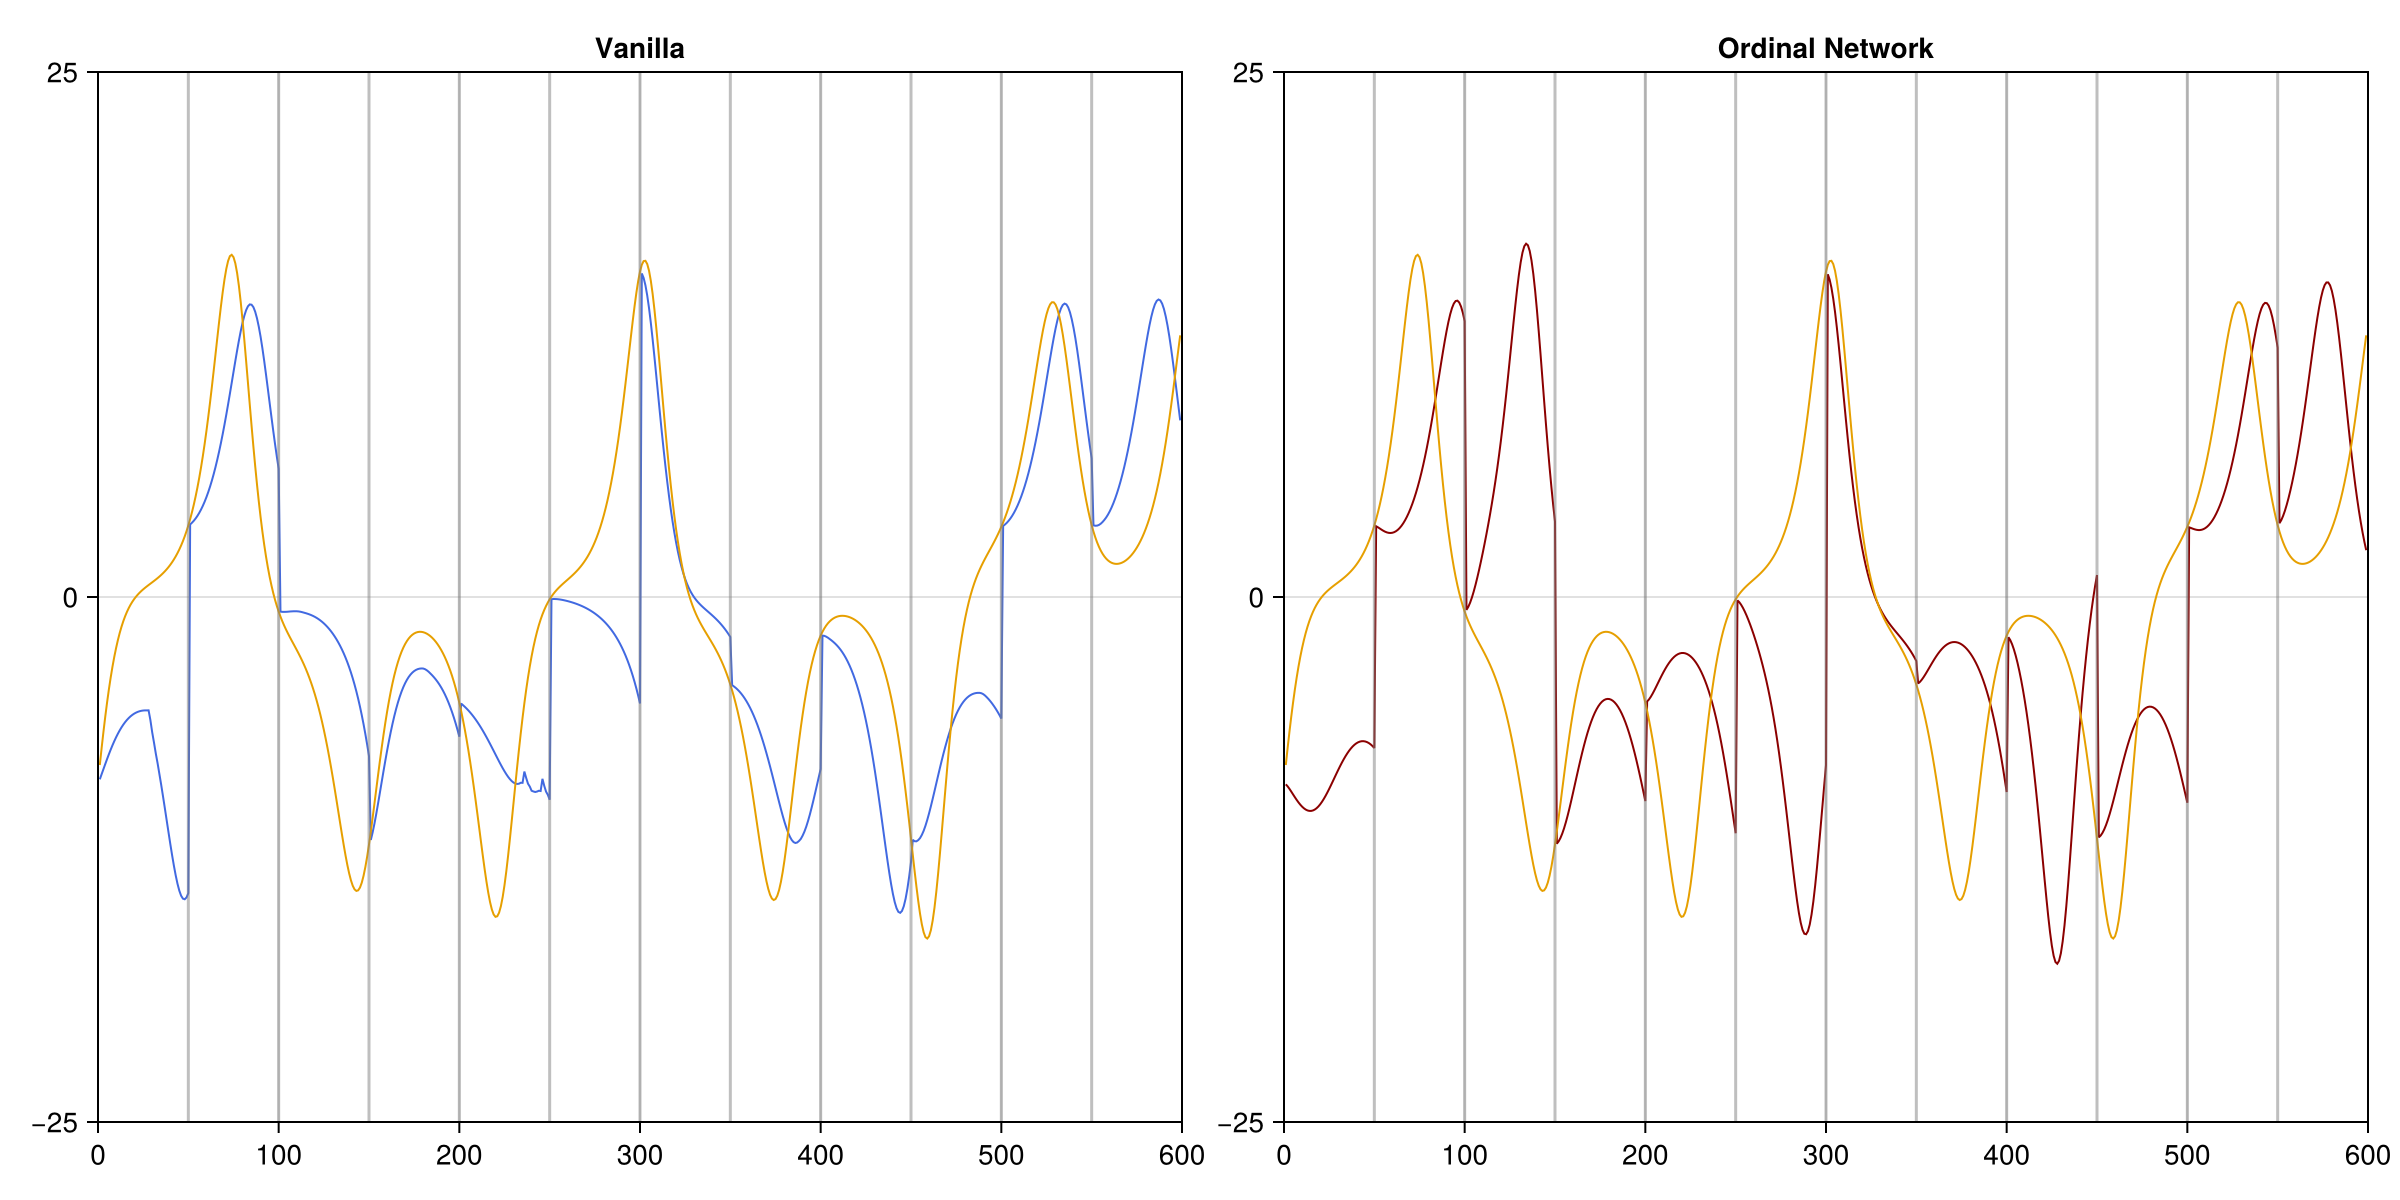

In [20]:
test_multi_step(lo_train, lo_test, 3, 100, n_steps=50, from=0, to=600; ignore_first=100)

Created reservoir of size: (600,)


Created reservoir of size: (600,)


Overall RMSE:
    Vanilla: 3.258012010720273
    Ordinal network reservoir: 4.82531572370914
Turning partition RMSE:
    Vanilla: 3.8929526111687207
    Ordinal network reservoir: 5.584167576502982


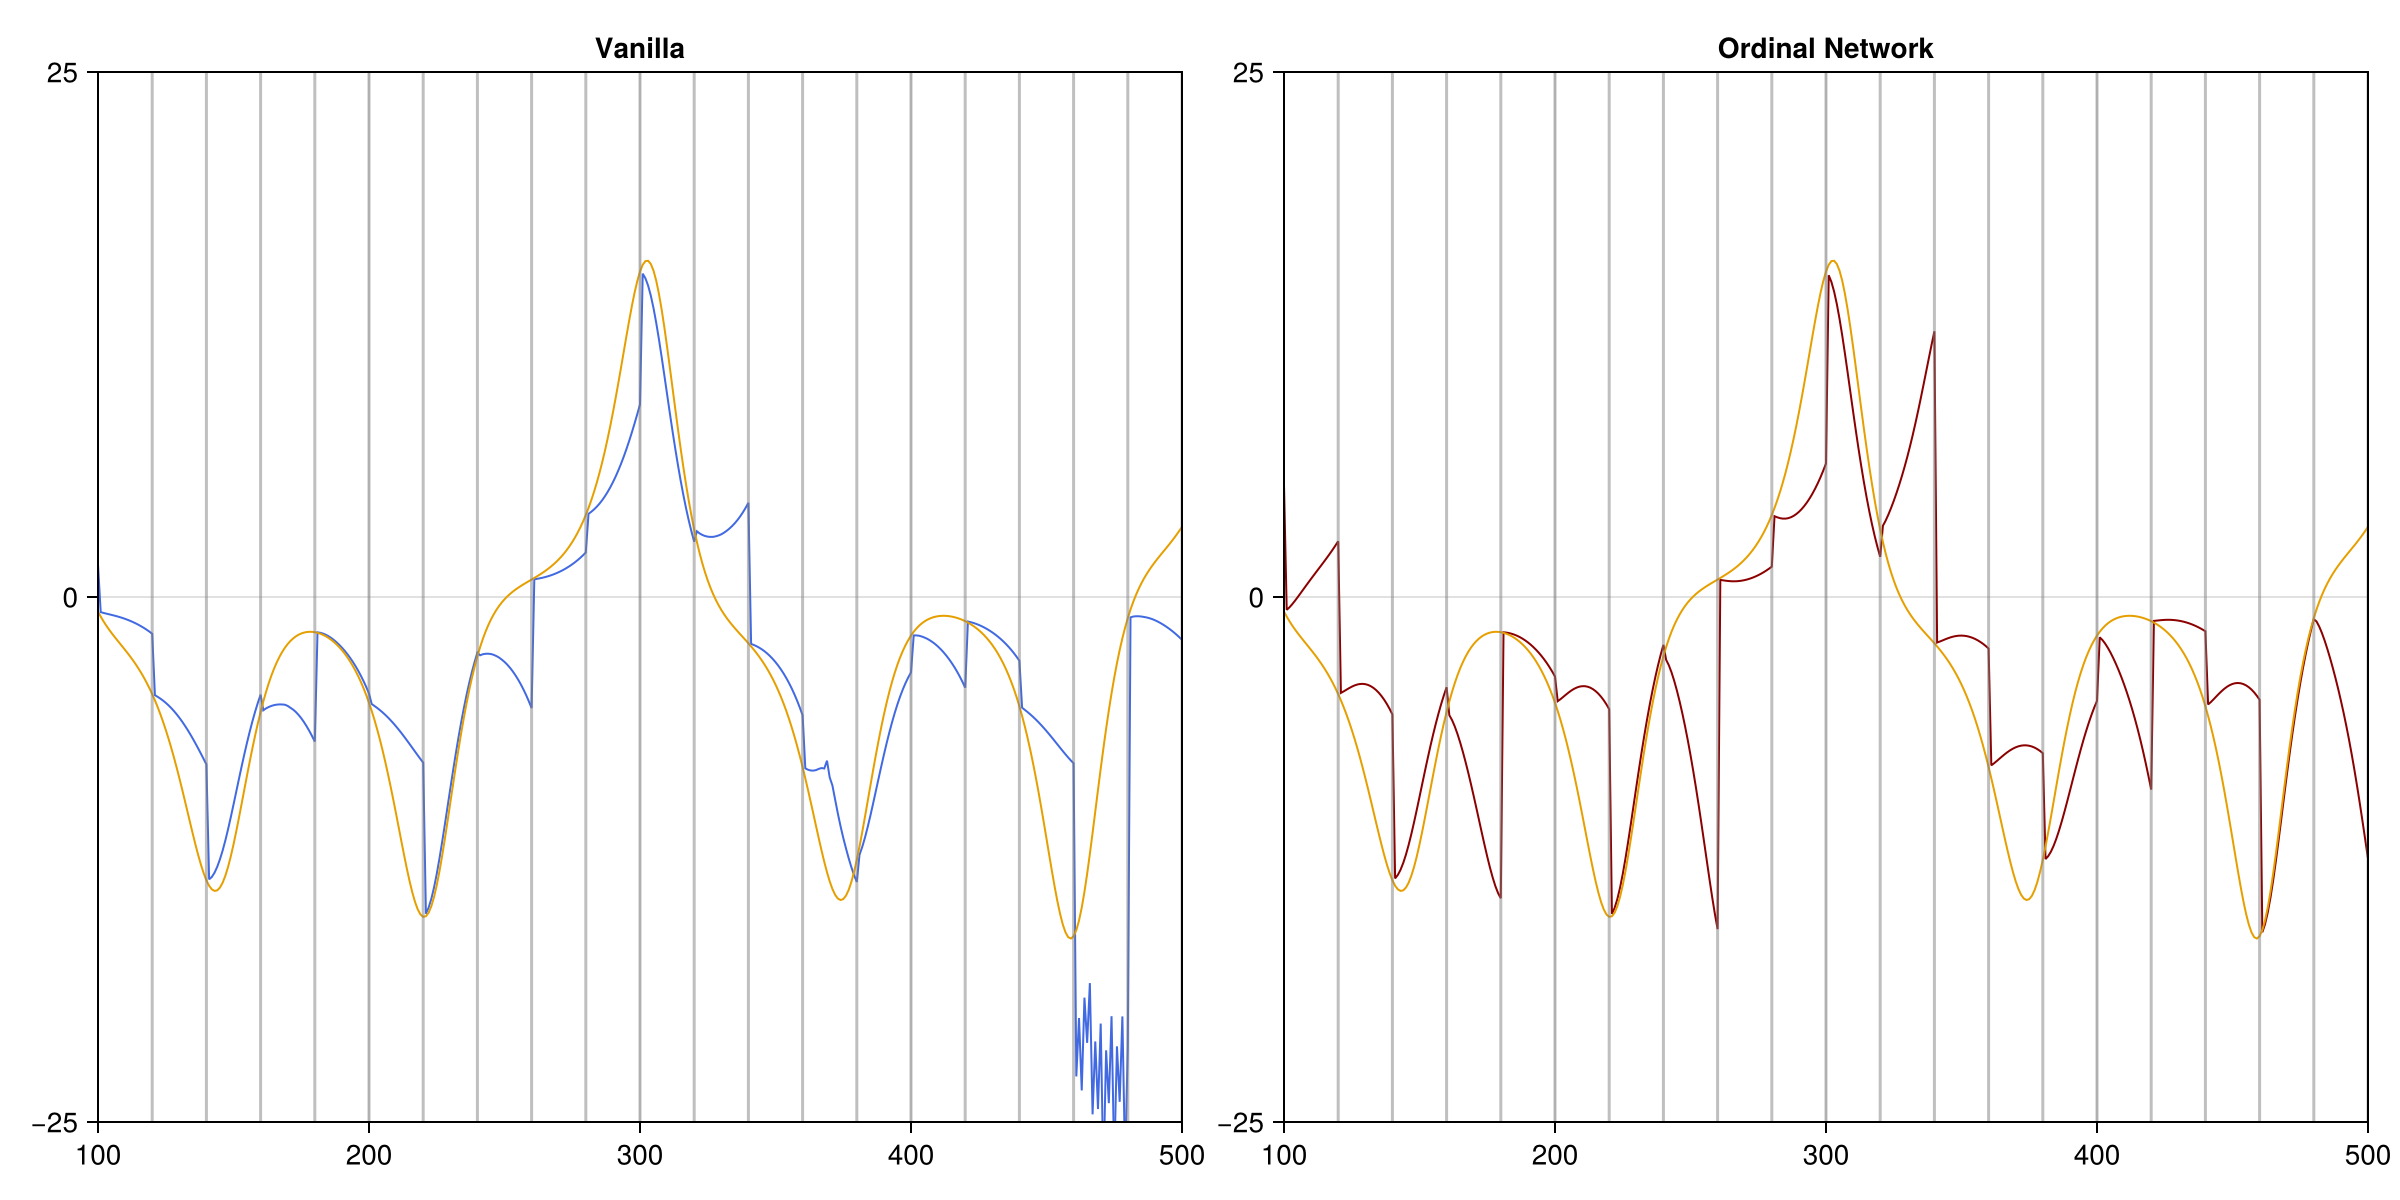

In [21]:
test_multi_step(lo_train, lo_test, 4, 100, n_steps=20, from=100, to=500)

Created reservoir of size: (2400,)


Created reservoir of size: (2400,)


Overall RMSE:
    Vanilla: 1.6844827824116342
    Ordinal network reservoir: 1.190564081384711
Turning partition RMSE:
    Vanilla: 1.6287624164192689
    Ordinal network reservoir: 0.6907764955186297


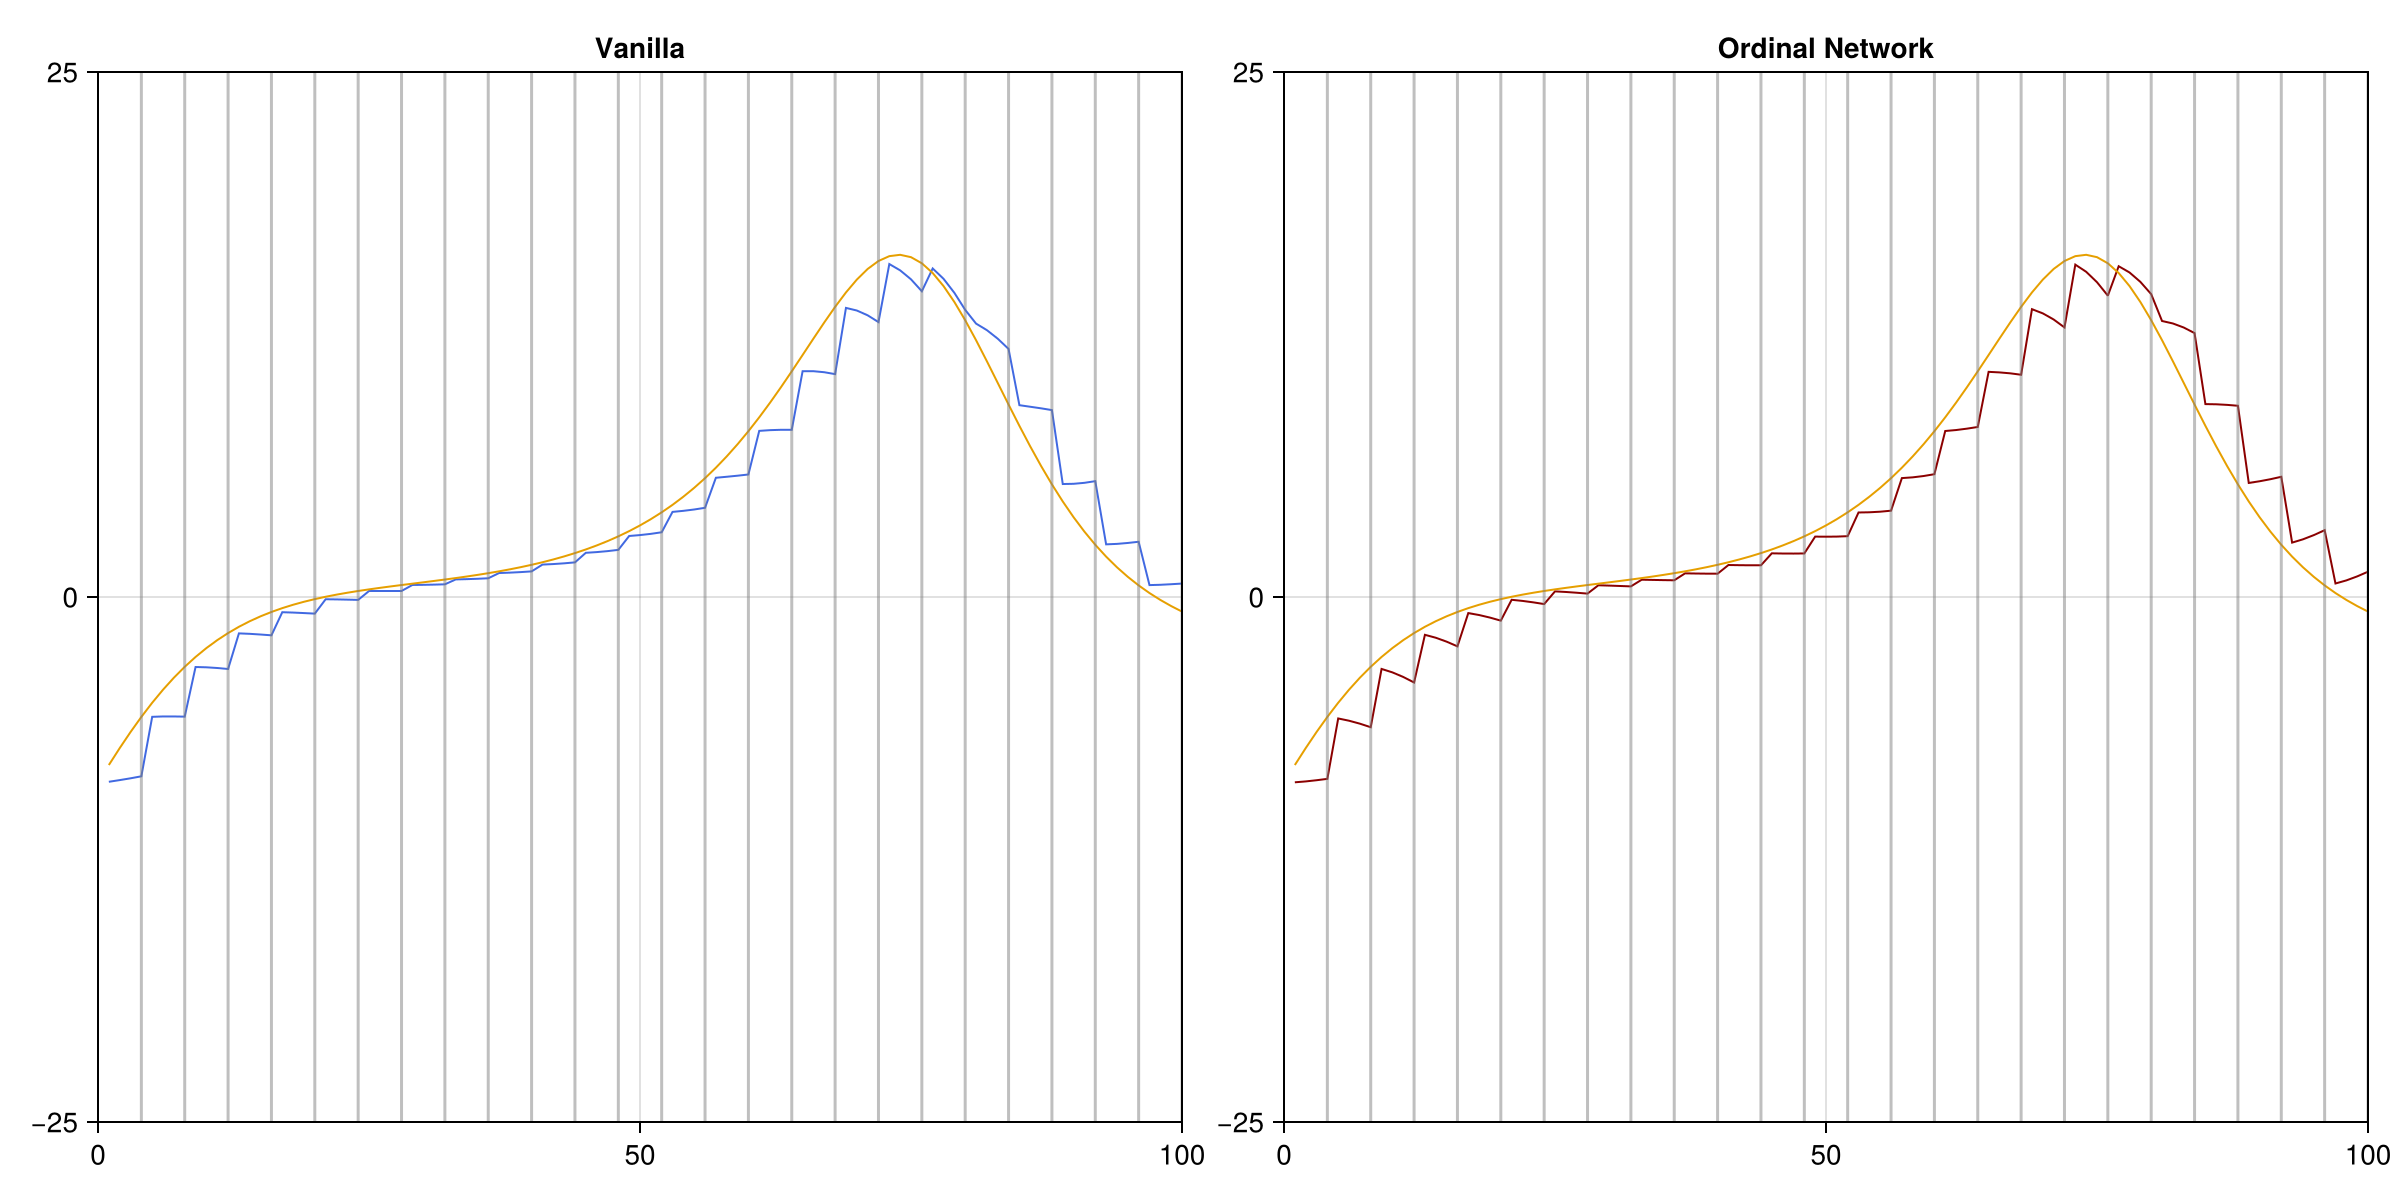

In [22]:
test_multi_step(lo_train, lo_test, 3, 400, n_steps=4, from=0, to=100)